### Methods and Packages 

In [1]:
%run methods_sulfate_deposition.ipynb

/Users/feliciacarlborg/opt/anaconda3/lib/python3.8/site-packages/nbformat/__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
import warnings 
from tabulate import tabulate
from scipy import interpolate
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import itertools
from tqdm import tqdm
import seaborn as sns
from scipy.stats.stats import pearsonr
import math
from matplotlib.widgets import Slider, RadioButtons
from sklearn.linear_model import LinearRegression

np.set_printoptions(threshold=np.inf)
sns.set_theme(context='paper', style='white', palette='bright',font='arial')

## Bipolar Eruptions 

In [3]:
exc_sheet_bp_mp = pd.ExcelFile('Bipolar match points ver 2022-12-23.xls')
bp_mp = pd.read_excel(exc_sheet_bp_mp, 'Sheet1')
bp_mp = np.array(bp_mp)

depth_bp_NGRIP = np.array(bp_mp[:,0], dtype='float64')
depth_bp_EDC = np.array(bp_mp[:,2], dtype='object')
depth_bp_EDC[depth_bp_EDC==' '] = np.nan
depth_bp_EDC = np.array(depth_bp_EDC, dtype='float64')

### Excel files 

In [4]:
### Downloading excel files ###
sheet9 = pd.ExcelFile('EDC_FIC_on_GICC05.xls')
EDC = pd.read_excel(sheet9, 'Sheet1')
sheet10 = pd.ExcelFile('AICC2012_official.xls')
thinning = pd.read_excel(sheet10, 'EDC')
sheet11= pd.ExcelFile('EDC_d18O_on_GICC05.xls')
d18O = pd.read_excel(sheet11, 'Sheet1')
linetal = pd.ExcelFile('Supplementary tables.xls')
sp = pd.read_excel(linetal, 'Table S4')

sheet12 = pd.ExcelFile('EDC96-EDC99_conversion.xls')
conv = pd.read_excel(sheet12, 'Sheet1')

sheet13 = pd.ExcelFile('my_conversion_EDC99_EDC96.xlsx')
my_conv = pd.read_excel(sheet13, 'Sheet1')


conv, my_conv

(     EDC99_depth(m)  EDC96_depth(m)
 0          0.000000         0.00000
 1         12.130000        12.31000
 2         29.600000        29.73000
 3         37.930000        38.11000
 4         39.070000        39.24000
 ..              ...             ...
 388      750.648316       751.32855
 389      750.870279       751.55070
 390      752.036066       752.71747
 391      753.396550       754.07910
 392      762.220666       762.91065
 
 [393 rows x 2 columns],
       EDC96   EDC99
 0     12.31   12.13
 1     29.73   29.60
 2     38.11   37.93
 3     39.24   39.07
 4     40.78   40.56
 ..      ...     ...
 99   751.05  750.37
 100  762.93  762.24
 101  765.55  764.96
 102  775.73  775.04
 103  778.33  777.64
 
 [104 rows x 2 columns])

### Here I will try to convert the EDC96 to EDC99

775.04

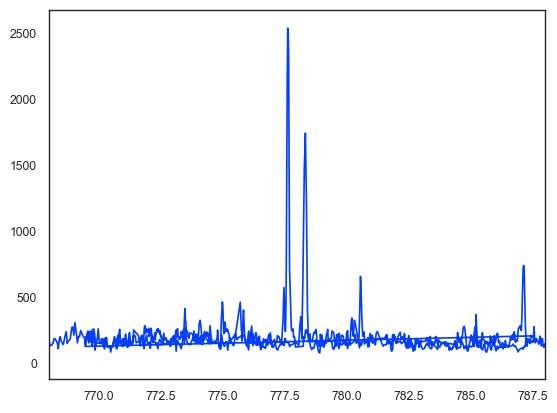

In [5]:
## array with EDC99 and EDC96 depth ## 

my_conv = np.array(my_conv)
my_conv = my_conv[1:,:]
EDC = np.array(EDC)
conv = np.array(conv)
EDC99_depth = np.concatenate((conv[:,0], my_conv[97:102,1]), axis=0)
EDC96_depth = np.concatenate((conv[:,1], my_conv[97:102,0]), axis=0)

### arrays for original EDC data ###
EDC_depth = EDC[:,0]
EDC_sulfate = EDC[:,1]
EDC_age = EDC[:,3]
EDC_thickness = EDC_depth[1:] - EDC_depth[:-1]

plt.figure()
plt.plot(EDC_depth, EDC_sulfate)
plt.xlim(768,788)

EDC99_depth[-1]

### Variables from excel files 

In [6]:
### Pandas to array ###
thinning = np.array(thinning)
d18O = np.array(d18O)
sp = np.array(sp)

### Picking the different arrays ###
EDC_depth = EDC[:,0]
EDC_sulfate = EDC[:,1]
EDC_age = EDC[:,3]
EDC_thickness = EDC_depth[1:] - EDC_depth[:-1]

### Double data around 44k is fixed (only saving higher resolution data) ###

idx = np.where(EDC_depth == 769.46)[0][0]
idx2 = np.where(EDC_depth == 769.473)[0][0]
idx_lr = np.where(EDC_depth == 787.533)[0][0]
idx2_lr = np.where(EDC_depth == 787.542)[0][0]

print(EDC_age[idx], EDC_age[idx_lr])

print(idx, idx2, idx_lr, idx2_lr)

EDC_depth_1 = EDC_depth[:idx]
EDC_depth_2 = EDC_depth[idx2:]
EDC_age_1 = EDC_age[:idx]
EDC_age_2 = EDC_age[idx2:]
EDC_sulfate_1 = EDC_sulfate[:idx]
EDC_sulfate_2 = EDC_sulfate[idx2:]

EDC_depth_1_interp = np.interp(EDC_depth_1, EDC96_depth, EDC99_depth)
EDC_sulfate_1_interp = np.interp(EDC_depth_1_interp, EDC_depth_1, EDC_sulfate_1)
EDC_age_1_interp = np.interp(EDC_depth_1_interp, EDC_depth_1, EDC_age_1)


EDC_depth = np.concatenate((EDC_depth_1,EDC_depth_2), axis=None)
EDC_age = np.concatenate((EDC_age_1, EDC_age_2), axis=None)
EDC_sulfate = np.concatenate((EDC_sulfate_1, EDC_sulfate_2), axis=None)

###just for checking lr data ###

EDC_depth_11 = EDC_depth[:idx_lr]
EDC_depth_22 = EDC_depth[idx2_lr:]
EDC_age_11 = EDC_age[:idx_lr]
EDC_age_22 = EDC_age[idx2_lr:]
EDC_sulfate_11 = EDC_sulfate[:idx_lr]
EDC_sulfate_22 = EDC_sulfate[idx2_lr:]

EDC_depth_lr = np.concatenate((EDC_depth_11,EDC_depth_22), axis=None)
EDC_age_lr = np.concatenate((EDC_age_11, EDC_age_22), axis=None)
EDC_sulfate_lr = np.concatenate((EDC_sulfate_11, EDC_sulfate_22), axis=None)

### Thickness between the samples ### 
EDC_thickness = EDC_depth[1:] - EDC_depth[:-1]

### Thinning arrays ###
EDC_thinning_depth = thinning[1:,0]
EDC_thinning = thinning[1:,6]
#EDC_acc = thinning[1:,5]

### Oxygen Isotope ### 
EDC_d18O = d18O[:,1]
EDC_d18O_age = d18O[:,4]
EDC_d18O_depth= d18O[:,0]
EDC_acc = d18O[:,5]

### Results from Lin et al 2022 ###
EDC_L_dep = sp[1:,4]
EDC_L_depth = sp[1:,6]
EDC_L_age = sp[1:,12]

### Storing some arrays ###
%store EDC_depth
%store EDC_thickness 
%store EDC_age
%store EDC_sulfate
%store EDC_thinning
%store EDC_thinning_depth
%store -r EDC_convolved_t
%store -r EDC_convolved_a
%store -r NGRIP_age
%store -r NGRIP_sulfate

44030.766823161175 45710.58326890692
10388 10753 10751 11543
Stored 'EDC_depth' (ndarray)
Stored 'EDC_thickness' (ndarray)
Stored 'EDC_age' (ndarray)
Stored 'EDC_sulfate' (ndarray)
Stored 'EDC_thinning' (ndarray)
Stored 'EDC_thinning_depth' (ndarray)


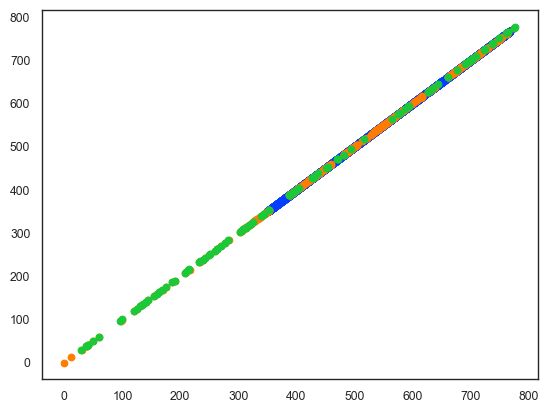

In [8]:
%matplotlib inline
plt.figure()
plt.scatter(EDC_depth_1, EDC_depth_1_interp)
plt.scatter(EDC96_depth, EDC99_depth)
plt.scatter(my_conv[:,1], my_conv[:,0])

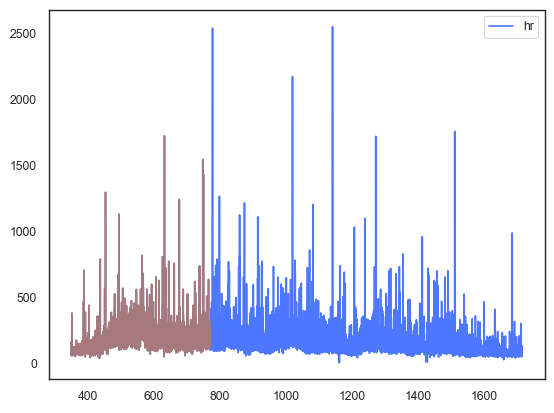

In [9]:
%matplotlib inline
plt.figure()
#plt.plot(EDC_depth_lr, EDC_sulfate_lr, label='lr')
plt.plot(EDC_depth, EDC_sulfate, label='hr', alpha=.7)
plt.plot(EDC_depth_1, EDC_sulfate_1, alpha=.5)
#plt.plot(EDC_depth_1, EDC_sulfate_1, label='1')
#plt.plot(EDC_depth_2, EDC_sulfate_2, label='2')
#plt.plot(EDC_depth_11, EDC_sulfate_11, label='11')
#plt.plot(EDC_depth_22, EDC_sulfate_22, label='22')
#plt.xlim(750,850)

plt.legend()

### Checking high and low resolution data since EDC96 and EDC99 are overlapping 

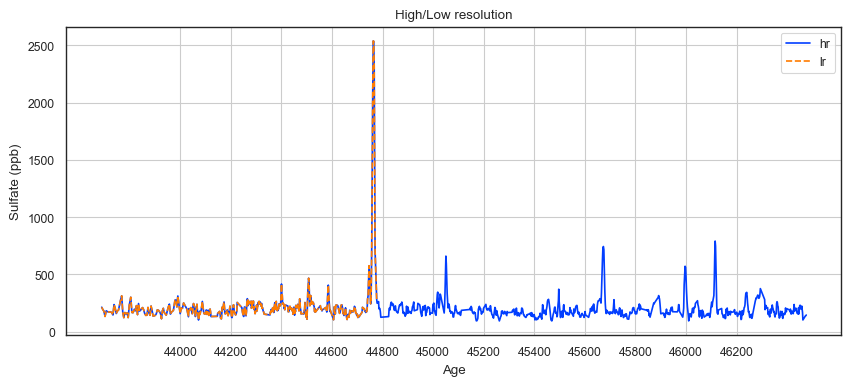

In [10]:
### Code to check the hr/lr data ###

ix = np.where((EDC_depth >= 766) & (EDC_depth <= 796) )
ix2 = np.where((EDC_depth_lr >= 766) & (EDC_depth_lr <= 796) )

ticks = np.arange(44000, 46400, 200)

plt.figure(figsize=(10,4))
plt.plot(EDC_age[ix], EDC_sulfate[ix], label='hr')
plt.plot(EDC_age_lr[ix2], EDC_sulfate_lr[ix2], label ='lr', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Sulfate (ppb)')
plt.title('High/Low resolution')
#plt.xlim(44000, 47000)
plt.xticks(ticks, ticks)
plt.grid('minor')
plt.legend()
plt.savefig('EDC96_EDC_99_age_comparison')
plt.show()

### Interpolating arrays to fit the correct depth data

In [11]:
### accumulation rate for correct time line ### 
EDC_acc = np.array(EDC_acc, dtype='float64')
EDC_thinning = np.array(EDC_thinning, dtype='float64')
EDC_thinning_depth = np.array(EDC_thinning_depth, dtype='float64')
EDC_depth_interp_th = (EDC_depth[:-1] + EDC_depth[1:])/2 #evaluating thinning from middle of samples

EDC_acc_corr = np.interp(EDC_depth, EDC_d18O_depth, EDC_acc) #accumulation data
EDC_d18O_wdepth = np.interp(EDC_depth, EDC_d18O_depth, EDC_d18O) #d18O data
EDC_thinning_corr = np.interp(EDC_depth_interp_th, EDC_thinning_depth, EDC_thinning) #thinning data

%store EDC_thinning_corr
%store EDC_depth_interp_th

len(EDC_thinning_corr), len(EDC_depth_interp_th), len(EDC_depth)

Stored 'EDC_thinning_corr' (ndarray)
Stored 'EDC_depth_interp_th' (ndarray)


(56768, 56768, 56769)

## Original GICC05 timescale from NGRIP - So that all depths correspond to the correct age 

In [12]:
## Downloading data
excel = pd.ExcelFile('2010-11-19 GICC05modelext for NGRIP 2.xls')
GICC05 = pd.read_excel(excel, 'GICC05')
GICC05= np.array(GICC05)

NGRIP_age_GICC05 = np.array(GICC05[70:, 0], dtype='float64')
NGRIP_depth_GICC05 = np.array(GICC05[70:, 1], dtype='float64')

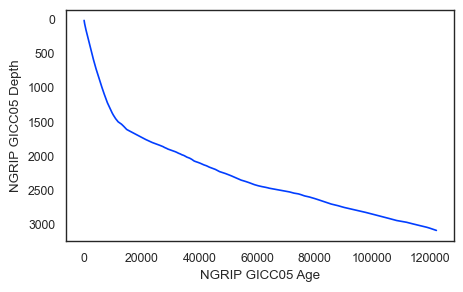

In [13]:
## This is the GICC05 timeseries that we want all our cores to be in. 
plt.figure(figsize=(5,3))
plt.plot(NGRIP_age_GICC05, NGRIP_depth_GICC05)
plt.xlabel('NGRIP GICC05 Age')
plt.ylabel('NGRIP GICC05 Depth')
plt.gca().invert_yaxis()

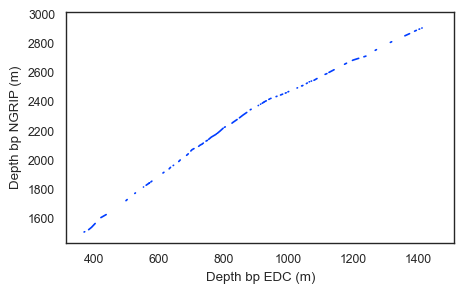

In [14]:
## This is along the points we want to start our first interpolation since they are connected.
plt.figure(figsize=(5,3)) 
plt.plot(depth_bp_EDC, depth_bp_NGRIP)
plt.xlabel('Depth bp EDC (m)')
plt.ylabel('Depth bp NGRIP (m)')
plt.show()

In [15]:
#1. first interpolation. We want a new correspoding depth in NGRIP to fit the depth with EDC. 
lim_EDC = np.where( (EDC_depth > 369) & (EDC_depth < 1470))
ip = interpolate.interp1d(interp(depth_bp_EDC), interp(depth_bp_NGRIP), fill_value = 'extrapolate') ##interpolation so I get new depth for NGRIP
NGRIP_depth_new = ip(EDC_depth[lim_EDC])
##interpolating the nans for xp and fp since we want a smooth line to interpolate on. 

len(NGRIP_depth_new)

44314

Text(0, 0.5, 'NGRIP depth (new)')

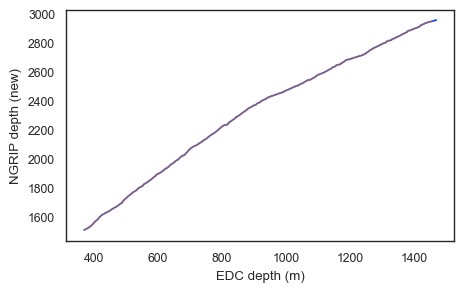

In [16]:
##The interpolated updated NGRIP depth 
plt.figure(figsize=(5,3))
plt.plot(EDC_depth[lim_EDC], NGRIP_depth_new )
plt.plot(depth_bp_EDC, depth_bp_NGRIP, alpha=.5)
plt.xlabel('EDC depth (m)')
plt.ylabel('NGRIP depth (new)')

In [17]:
#2. Second interpolation. Getting the EDML GICC05 age correct (that corresponds to our updated NGRIP depth (that corresponds to the depth of EDC))
ak = interpolate.Akima1DInterpolator(NGRIP_depth_GICC05, NGRIP_age_GICC05) ##Interpolation so I get the new age for EDC
EDC_age_new = ak(NGRIP_depth_new)
len(EDC_age_new)

44314

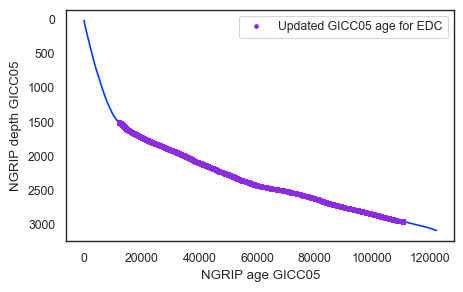

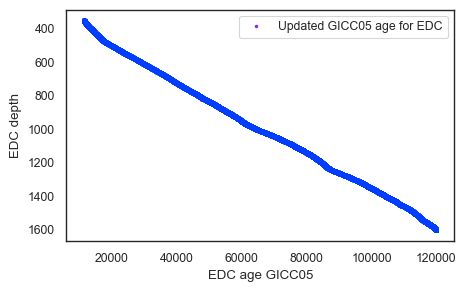

In [18]:
## The new EDC age vs the updated NGRIP depth (that corresponds to EDC depth)
%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(NGRIP_age_GICC05, NGRIP_depth_GICC05)
plt.plot(EDC_age_new, NGRIP_depth_new, 'm.', label='Updated GICC05 age for EDC')
plt.ylabel('NGRIP depth GICC05')
plt.xlabel('NGRIP age GICC05')
plt.gca().invert_yaxis()
plt.legend()

##updated EDML age for corresponding original EDML depth 
plt.figure(figsize=(5,3))
plt.plot(EDC_age_new, EDC_depth[lim_EDC], 'm.', label='Updated GICC05 age for EDC', markersize=3)
plt.plot(EDC_age, EDC_depth, '.')
plt.ylabel('EDC depth')
plt.xlabel('EDC age GICC05')
plt.gca().invert_yaxis()
plt.legend()

In [19]:
#storing the updated EDC_age 
%store EDC_age_new

EDC_age = np.copy(EDC_age_new)

len(EDC_age)

Stored 'EDC_age_new' (ndarray)


44314

### Median filters and interval lists for loop

In [20]:
### Median filters and age list ###
EDC_age_list = np.arange(10*1e3, 114*1e3,2000) #list with ages for the intervals 
EDC_filt_1 = np.arange(45,145,2) #list with the different filter lengths for RM
EDC_filt = np.insert(EDC_filt_1,0,45)
#EDC_filt =np.flip(EDC_filt)
#EDC_filt = np.ones(len(EDC_age_list))*201

len(EDC_age_list), len(EDC_age_list), len(EDC_filt)

(52, 52, 51)

In [22]:
thresholds = np.arange(.5,4.5,.5)

all_RMAD_EDC = pd.DataFrame()
all_RRM_EDC = pd.DataFrame()
    

for i in range(len(thresholds)):
    EDC_RRM_test = np.array([])
    EDC_RMAD_test = np.array([])
    
    print('i =', i)
    
    s = []
    
    for j in range(len(EDC_age_list)-1):
        
        idx = np.where((EDC_age >= EDC_age_list[j] - EDC_filt[j]) & (EDC_age < EDC_age_list[j+1] + EDC_filt[j]))
        #idx2 = np.where((EDC_age >= EDC_age_list[j]) & (EDC_age <= EDC_age_list[j+1]))
        idx_filt_1 = len(np.where((EDC_age >= EDC_age_list[j] - EDC_filt[j]) & (EDC_age < EDC_age_list[j]))[0])
        idx_filt_2 = len(np.where((EDC_age <= EDC_age_list[j+1] + EDC_filt[j]) & (EDC_age > EDC_age_list[j+1]))[0])
        
        if j == 0: 
            EDC_exl_volc_test= exl_volcanism(EDC_age[idx], EDC_sulfate[lim_EDC][idx],EDC_filt[j],thresholds[i])
            print('j=', j)
            EDC_RRM_test = np.concatenate( (EDC_RRM_test, running_median(EDC_age[idx], EDC_exl_volc_test, EDC_filt[j])[:-idx_filt_2]),  axis=None)
            EDC_RMAD_test = np.concatenate( (EDC_RMAD_test, median_of_absolute_deviation(EDC_age[idx],  EDC_exl_volc_test, EDC_filt[j], thresholds[i])[:-idx_filt_2]), axis=None)
                    
        elif j == (len(EDC_age_list) - 2):
            print('j=', j)
            EDC_exl_volc_test = exl_volcanism(EDC_age[idx], EDC_sulfate[lim_EDC][idx],EDC_filt[j],thresholds[i])
            EDC_RRM_test = np.concatenate( (EDC_RRM_test, running_median(EDC_age[idx], EDC_exl_volc_test, EDC_filt[j])[idx_filt_1:]),  axis=None)
            EDC_RMAD_test = np.concatenate( (EDC_RMAD_test, median_of_absolute_deviation(EDC_age[idx],  EDC_exl_volc_test, EDC_filt[j], thresholds[i])[idx_filt_1:]), axis=None)
            break
        
        else:
            print('j=', j)
            EDC_exl_volc_test = exl_volcanism(EDC_age[idx], EDC_sulfate[lim_EDC][idx],EDC_filt[j],thresholds[i])
            EDC_RRM_test = np.concatenate( (EDC_RRM_test, running_median(EDC_age[idx], EDC_exl_volc_test, EDC_filt[j])[idx_filt_1:-idx_filt_2]),  axis=None)
            EDC_RMAD_test = np.concatenate( (EDC_RMAD_test, median_of_absolute_deviation(EDC_age[idx],  EDC_exl_volc_test, EDC_filt[j], thresholds[i])[idx_filt_1:-idx_filt_2]), axis=None)
    
    #NEEM_exl_volc_test = np.array(NEEM_exl_volc_test)
    #NEEM_RRM_test = np.array(NEEM_RRM_test)
    #NEEM_RMAD_test = np.array(NEEM_RMAD_test)
      
    all_RRM_EDC[i] = EDC_RRM_test
    all_RMAD_EDC[i] = EDC_RMAD_test

i = 0
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
j= 15
j= 16
j= 17
j= 18
j= 19
j= 20
j= 21
j= 22
j= 23
j= 24
j= 25
j= 26
j= 27
j= 28
j= 29
j= 30
j= 31
j= 32
j= 33
j= 34
j= 35
j= 36
j= 37
j= 38
j= 39
j= 40
j= 41
j= 42
j= 43
j= 44
j= 45
j= 46
j= 47
j= 48
j= 49
j= 50
i = 1
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
j= 15
j= 16
j= 17
j= 18
j= 19
j= 20
j= 21
j= 22
j= 23
j= 24
j= 25
j= 26
j= 27
j= 28
j= 29
j= 30
j= 31
j= 32
j= 33
j= 34
j= 35
j= 36
j= 37
j= 38
j= 39
j= 40
j= 41
j= 42
j= 43
j= 44
j= 45
j= 46
j= 47
j= 48
j= 49
j= 50
i = 2
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
j= 15
j= 16
j= 17
j= 18
j= 19
j= 20
j= 21
j= 22
j= 23
j= 24
j= 25
j= 26
j= 27
j= 28
j= 29
j= 30
j= 31
j= 32
j= 33
j= 34
j= 35
j= 36
j= 37
j= 38
j= 39
j= 40
j= 41
j= 42
j= 43
j= 44
j= 45
j= 46
j= 47
j= 48
j= 49
j= 50
i = 3
j= 0
j= 1
j= 2
j= 3
j= 4
j= 5
j= 6
j= 7
j= 8
j= 9
j= 10
j= 11
j= 12
j= 13
j= 14
j= 15
j=

In [23]:
np.shape(all_RMAD_EDC), len(EDC_age[np.isfinite(EDC_age)]), len(EDC_sulfate[lim_EDC])

((44314, 8), 44314, 44314)

In [24]:
all_RMAD_EDC = np.array(all_RMAD_EDC)
all_RRM_EDC = np.array(all_RRM_EDC)

%store all_RMAD_EDC
%store all_RRM_EDC

len(all_RMAD_EDC[:,1])

Stored 'all_RMAD_EDC' (ndarray)
Stored 'all_RRM_EDC' (ndarray)


44314

### Plotting 2k intervals with sulfate background and d18O ###

  0%|          | 0/51 [00:00<?, ?it/s]

0 1 0


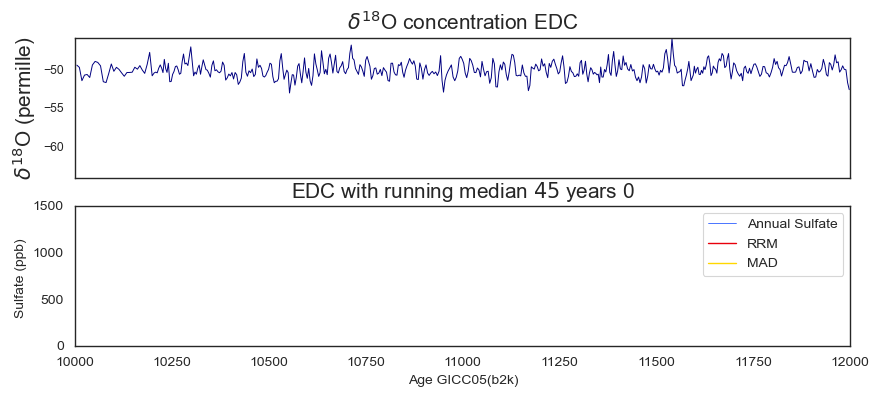

  2%|▏         | 1/51 [00:00<00:18,  2.64it/s]

1103 1 28
1 0 28


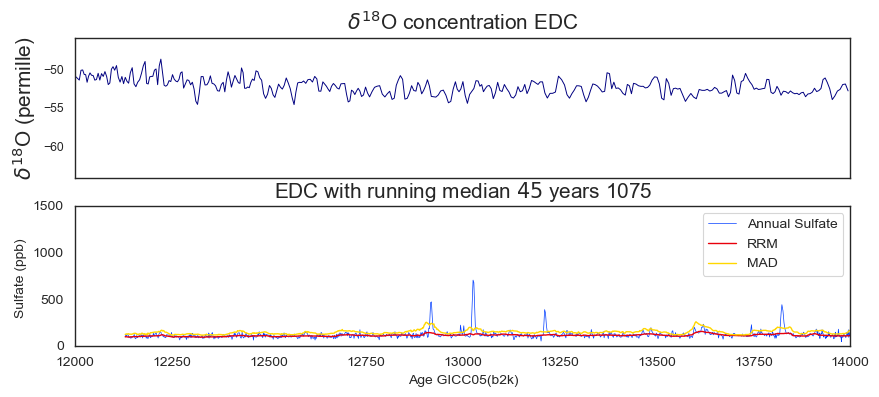

  4%|▍         | 2/51 [00:00<00:23,  2.05it/s]

1275 1 12
1 47 12


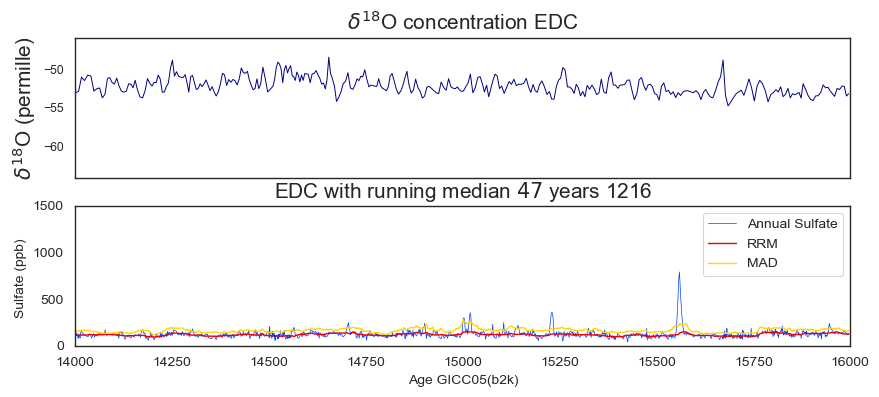

  6%|▌         | 3/51 [00:01<00:26,  1.79it/s]

907 1 10
1 12 10


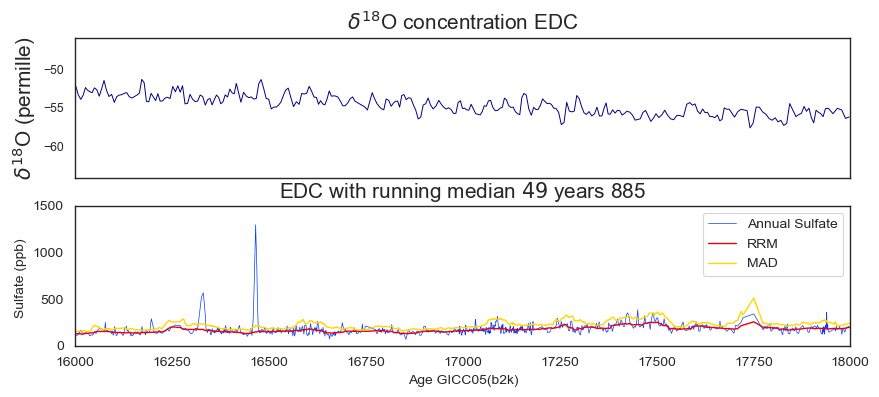

  8%|▊         | 4/51 [00:02<00:24,  1.90it/s]

610 1 13
1 18 13


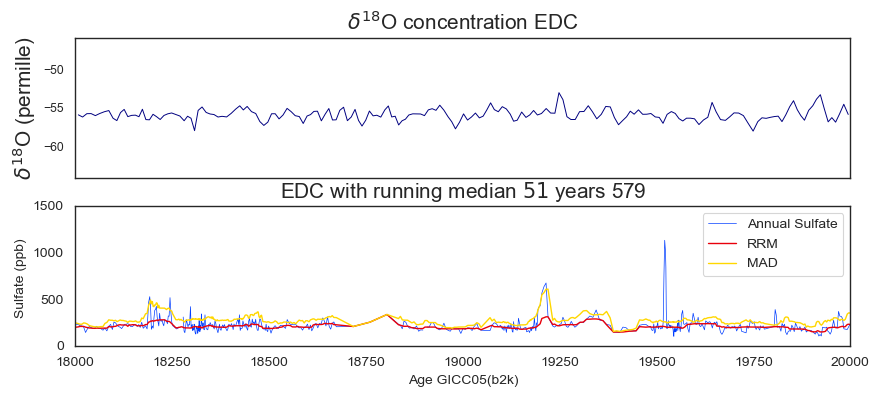

 10%|▉         | 5/51 [00:02<00:21,  2.14it/s]

607 1 21
1 16 21


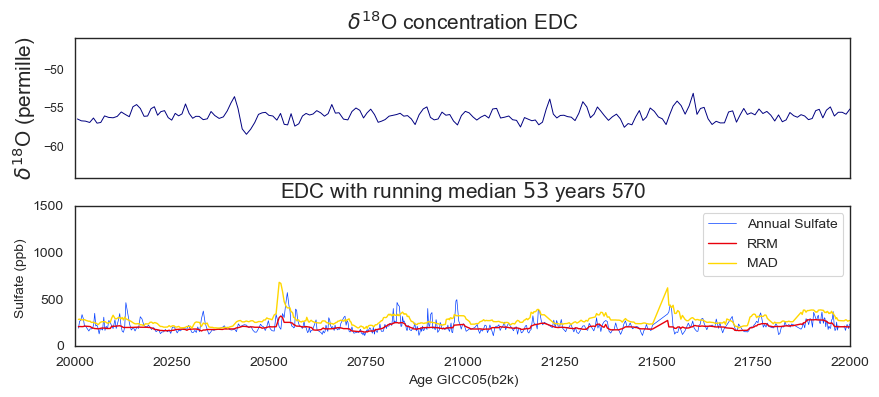

 12%|█▏        | 6/51 [00:02<00:19,  2.33it/s]

675 1 12
1 19 12


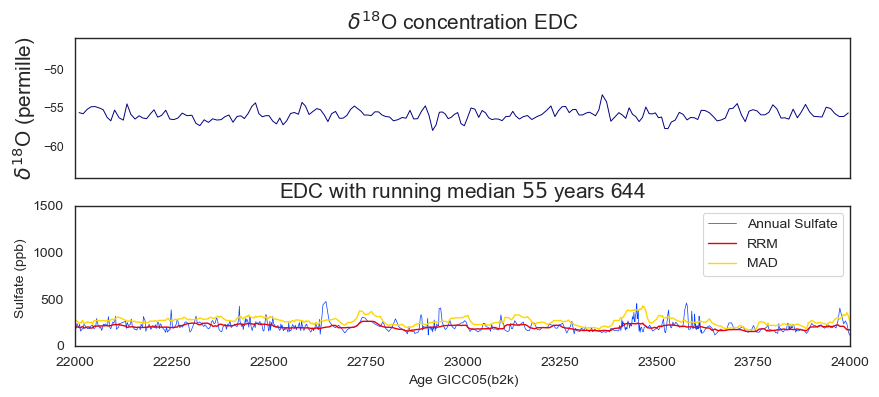

 14%|█▎        | 7/51 [00:03<00:18,  2.41it/s]

538 1 17
1 12 17


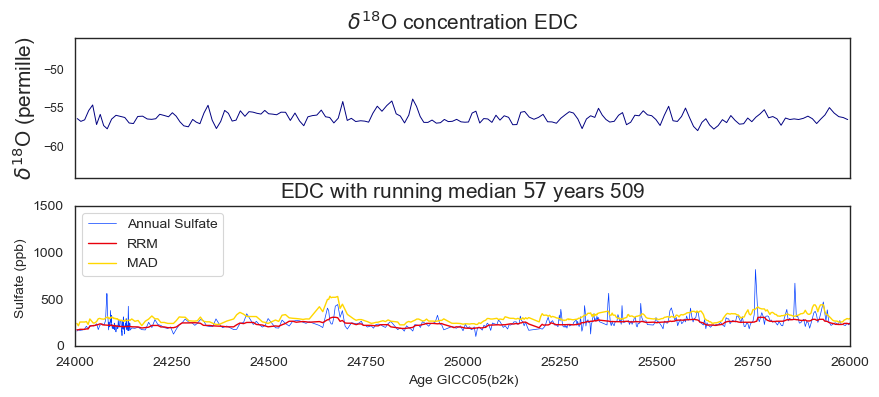

 16%|█▌        | 8/51 [00:03<00:16,  2.58it/s]

569 1 14
1 15 14


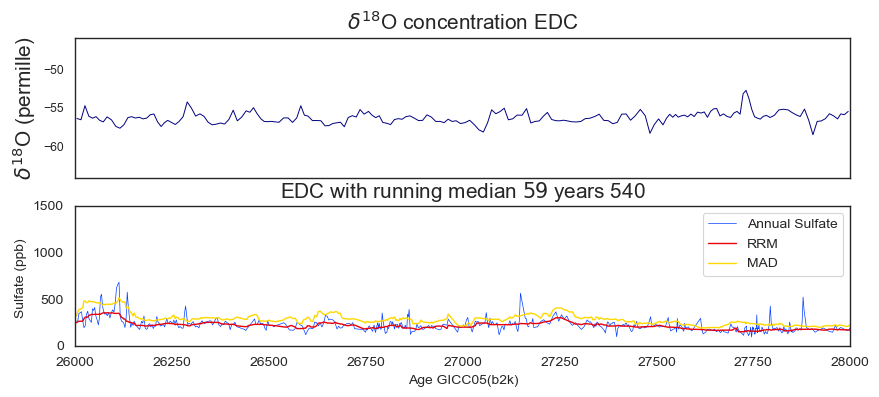

 18%|█▊        | 9/51 [00:03<00:15,  2.67it/s]

617 1 8
1 10 8


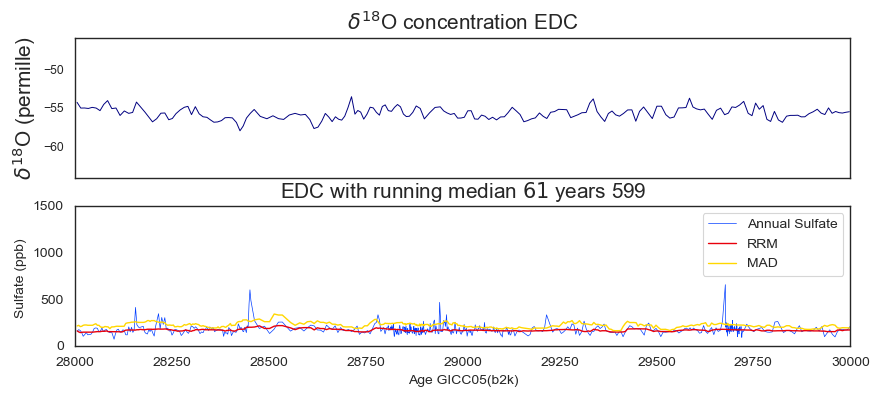

 20%|█▉        | 10/51 [00:04<00:20,  2.04it/s]

430 1 14
1 10 14


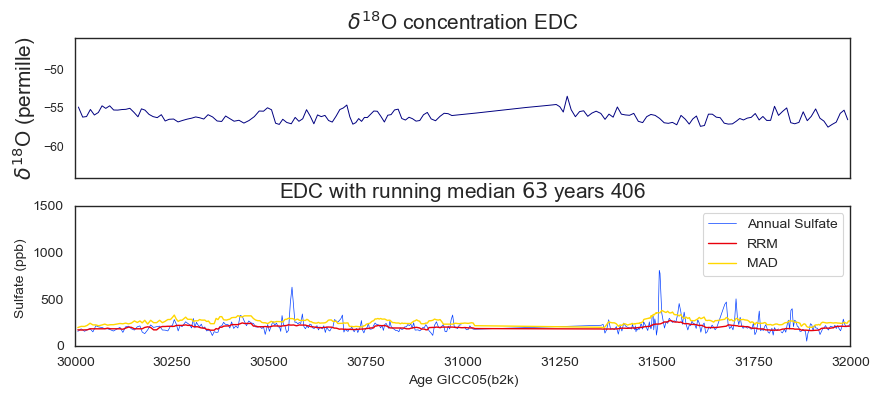

 22%|██▏       | 11/51 [00:04<00:17,  2.33it/s]

515 1 9
1 18 9


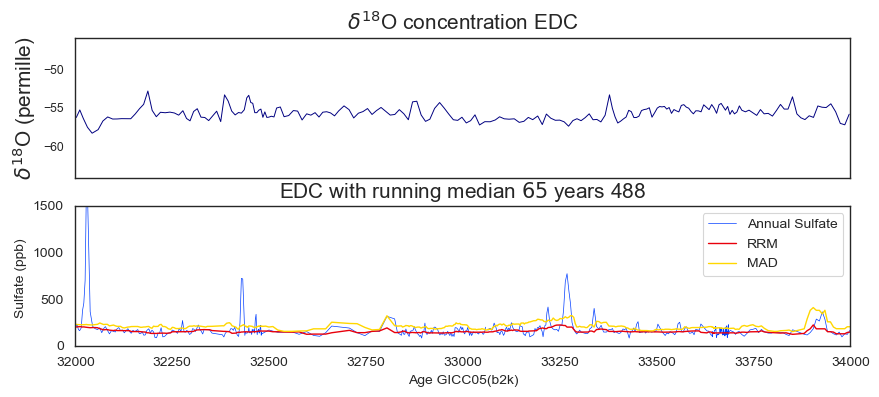

 24%|██▎       | 12/51 [00:05<00:15,  2.45it/s]

479 1 10
1 10 10


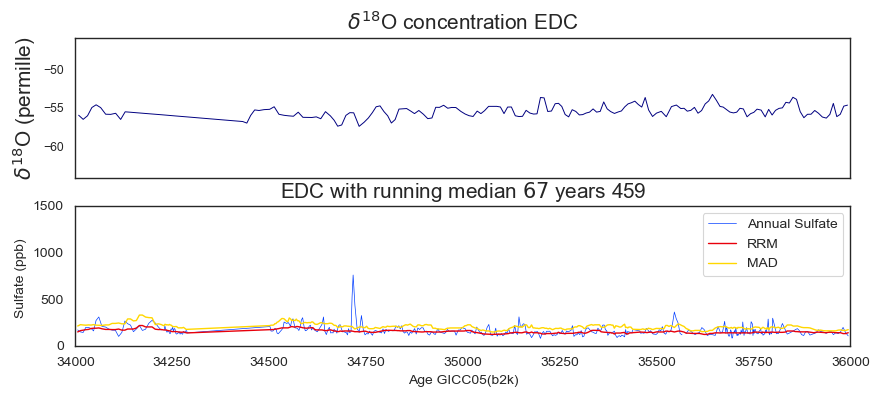

 25%|██▌       | 13/51 [00:05<00:14,  2.66it/s]

497 1 16
1 10 16


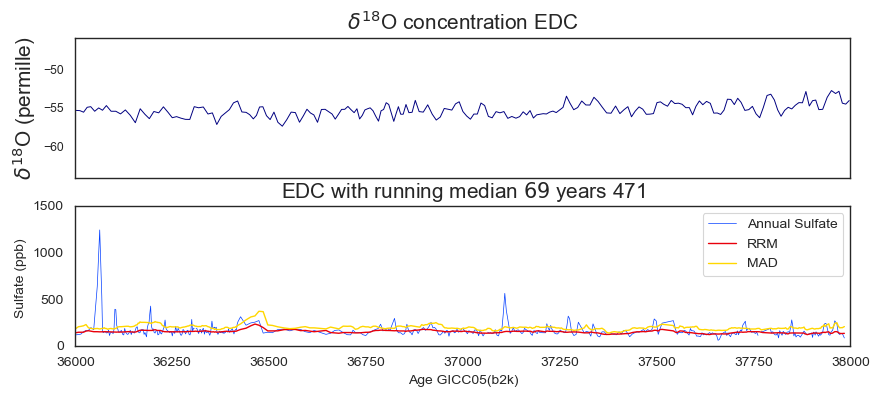

 27%|██▋       | 14/51 [00:05<00:13,  2.80it/s]

560 1 13
1 16 13


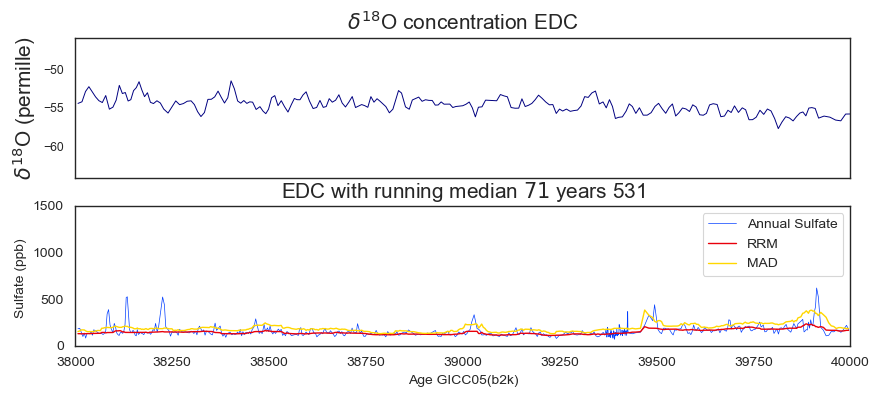

 29%|██▉       | 15/51 [00:06<00:12,  2.83it/s]

528 1 20
1 11 20


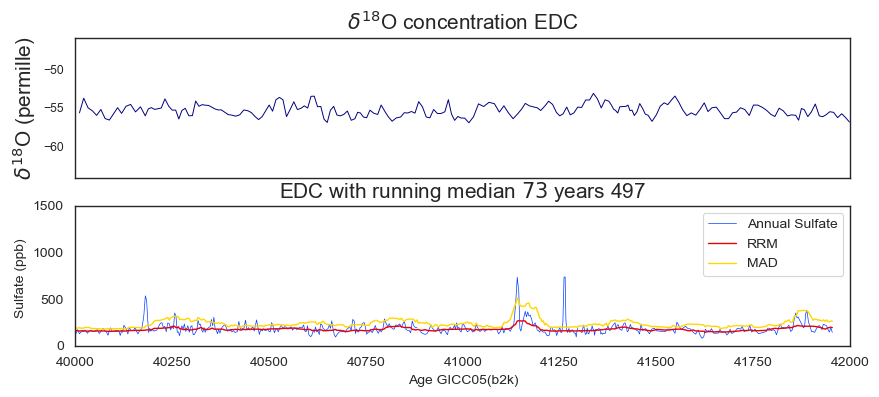

 31%|███▏      | 16/51 [00:06<00:12,  2.89it/s]

492 1 30
1 8 30


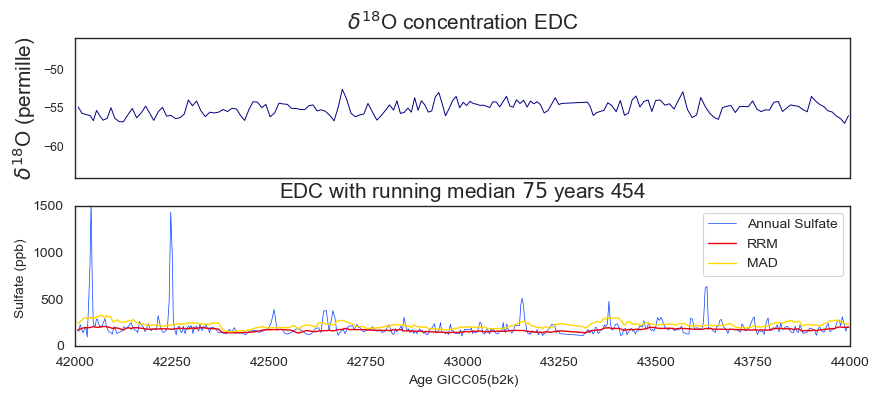

 33%|███▎      | 17/51 [00:06<00:11,  2.97it/s]

960 1 41
1 16 41


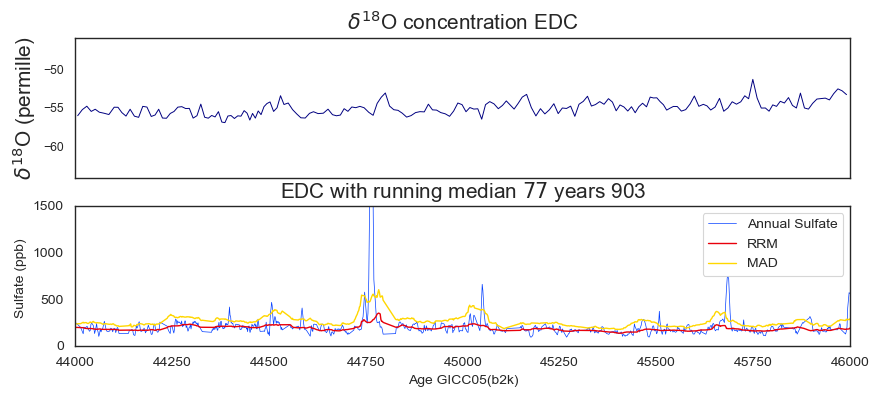

 35%|███▌      | 18/51 [00:07<00:12,  2.65it/s]

1321 1 7
1 27 7


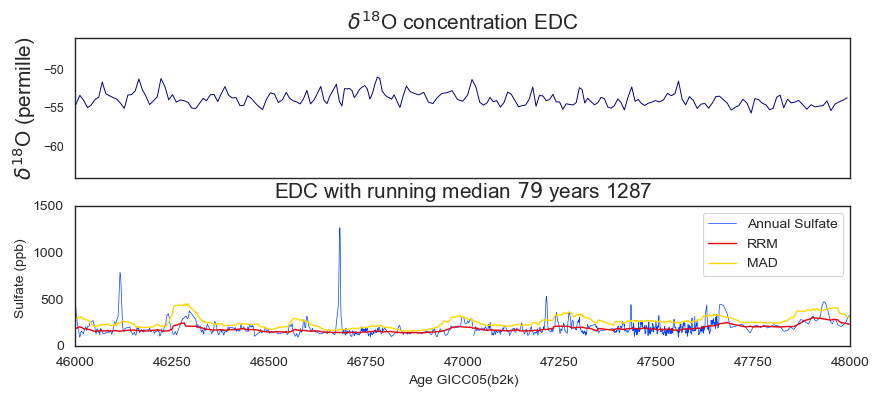

 37%|███▋      | 19/51 [00:07<00:14,  2.22it/s]

682 1 25
1 15 25


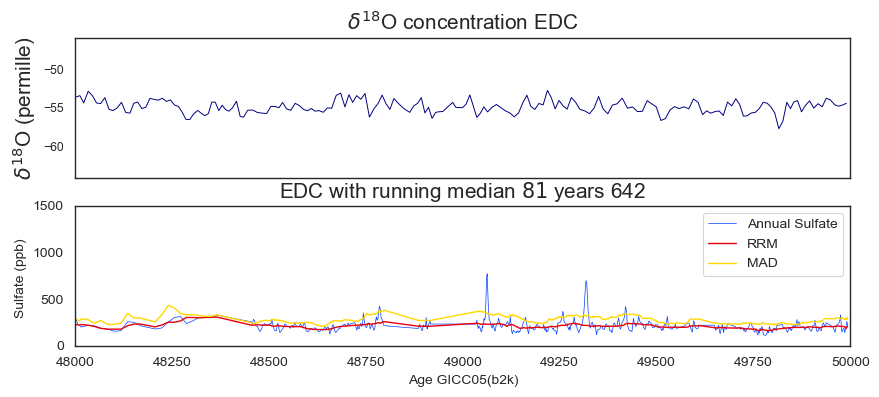

 39%|███▉      | 20/51 [00:08<00:13,  2.31it/s]

904 1 28
1 35 28


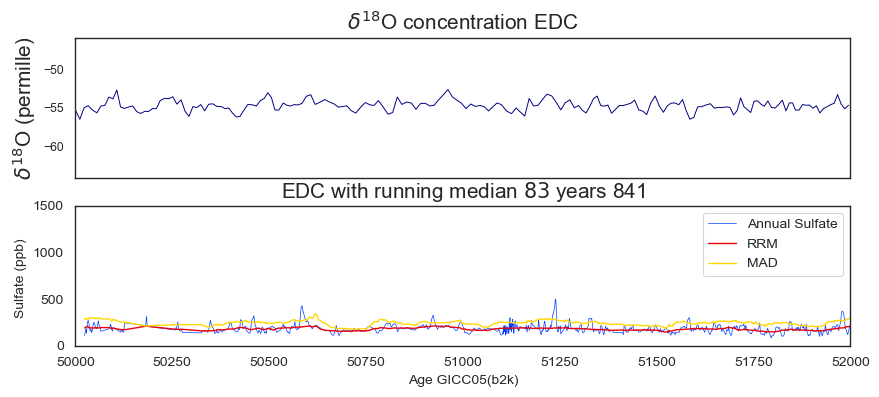

 41%|████      | 21/51 [00:08<00:13,  2.24it/s]

1156 1 46
1 44 46


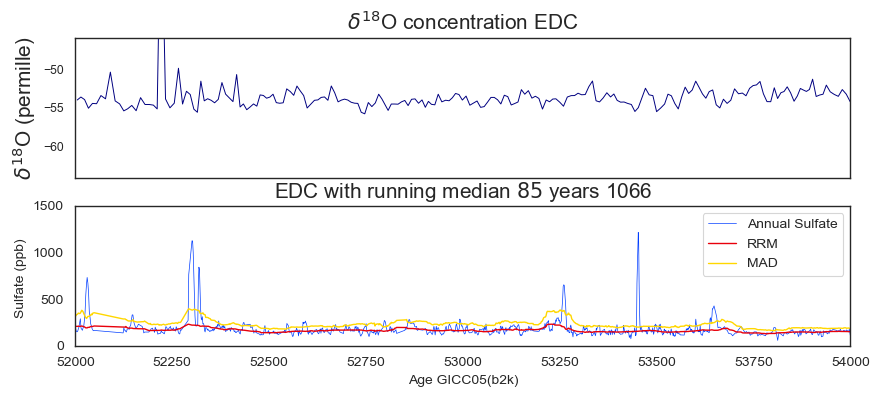

 43%|████▎     | 22/51 [00:09<00:16,  1.75it/s]

1298 1 18
1 37 18


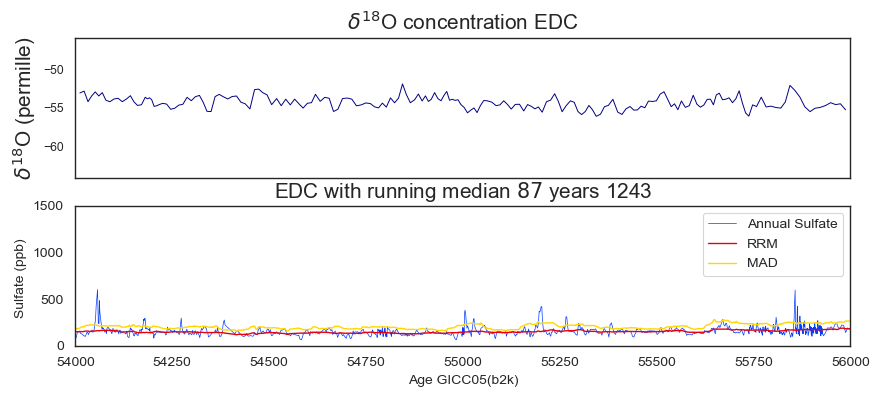

 45%|████▌     | 23/51 [00:10<00:16,  1.65it/s]

1127 1 66
1 78 66


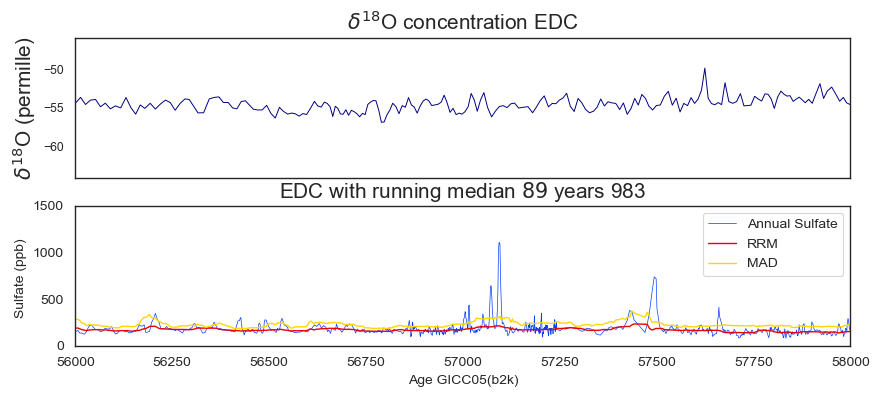

 47%|████▋     | 24/51 [00:11<00:16,  1.60it/s]

1408 1 60
1 49 60


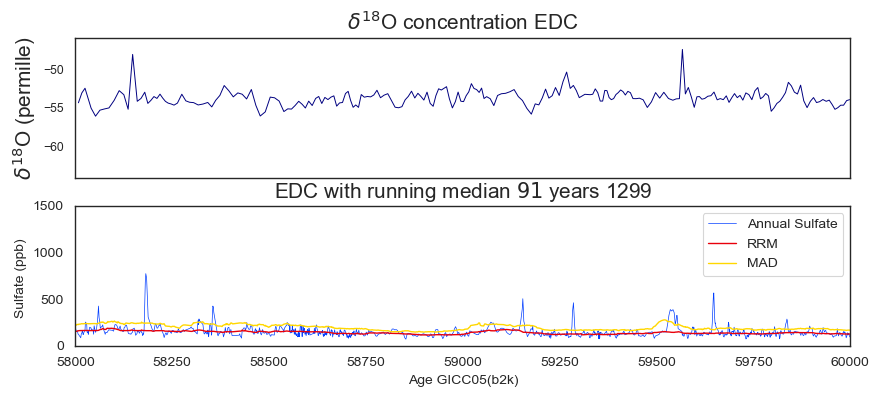

 49%|████▉     | 25/51 [00:11<00:16,  1.57it/s]

1362 1 44
1 57 44


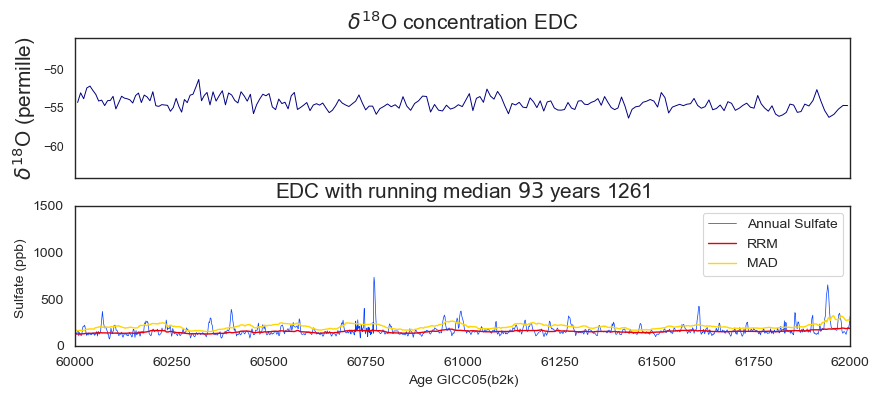

 51%|█████     | 26/51 [00:12<00:15,  1.57it/s]

1093 1 30
1 54 30


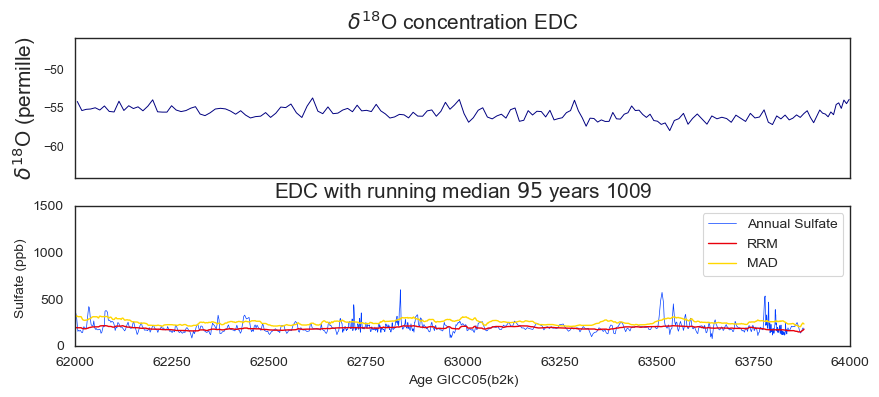

 53%|█████▎    | 27/51 [00:12<00:14,  1.64it/s]

782 1 23
1 0 23


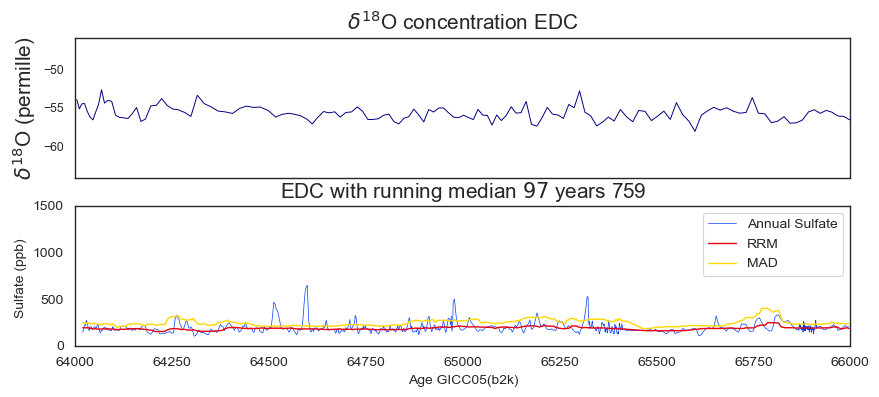

 55%|█████▍    | 28/51 [00:13<00:12,  1.80it/s]

843 1 38
1 42 38


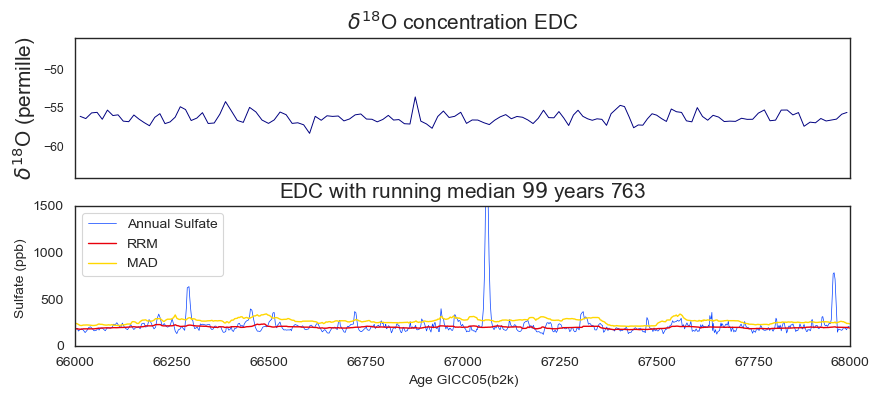

 57%|█████▋    | 29/51 [00:13<00:11,  1.85it/s]

874 1 28
1 45 28


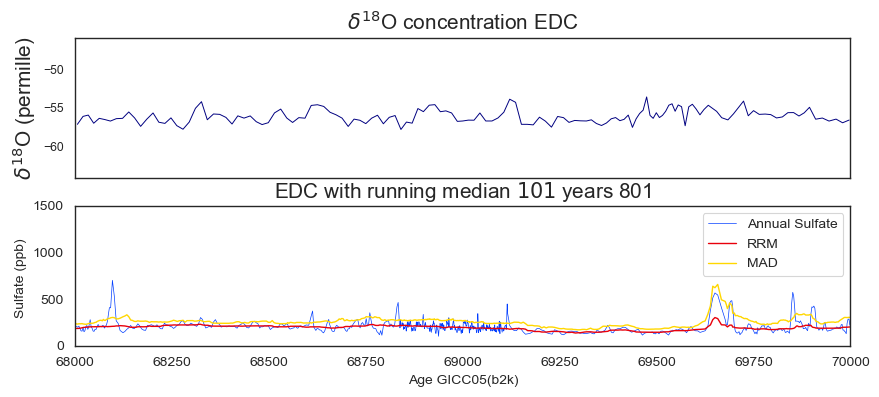

 59%|█████▉    | 30/51 [00:14<00:10,  1.93it/s]

1030 1 66
1 43 66


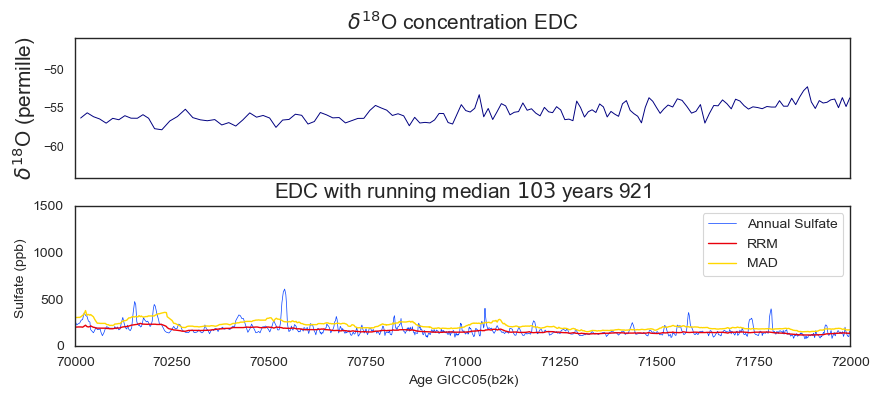

 61%|██████    | 31/51 [00:14<00:10,  1.93it/s]

1042 1 36
1 79 36


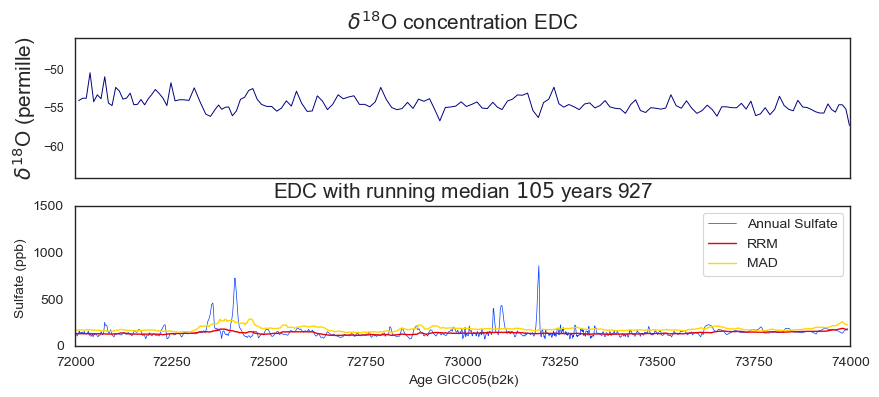

 63%|██████▎   | 32/51 [00:15<00:09,  1.93it/s]

1050 1 102
1 12 102


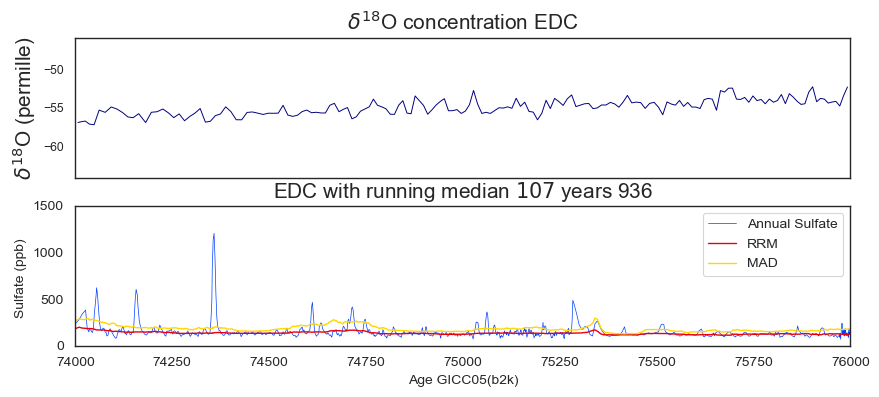

 65%|██████▍   | 33/51 [00:15<00:09,  1.92it/s]

1296 1 30
1 94 30


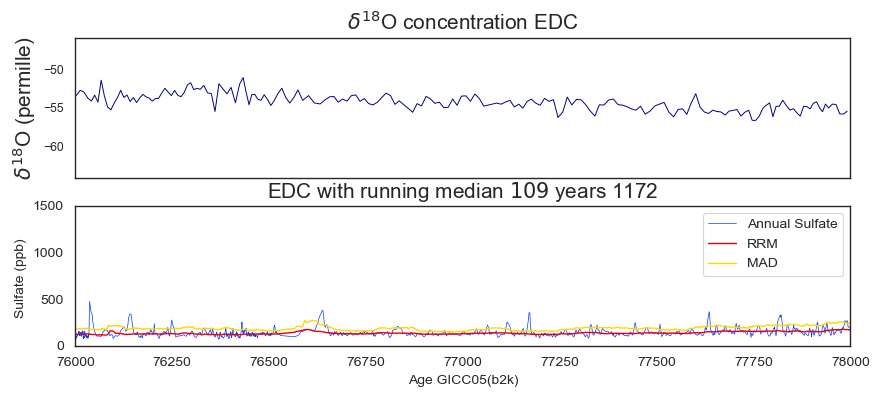

 67%|██████▋   | 34/51 [00:16<00:09,  1.82it/s]

1131 1 48
1 72 48


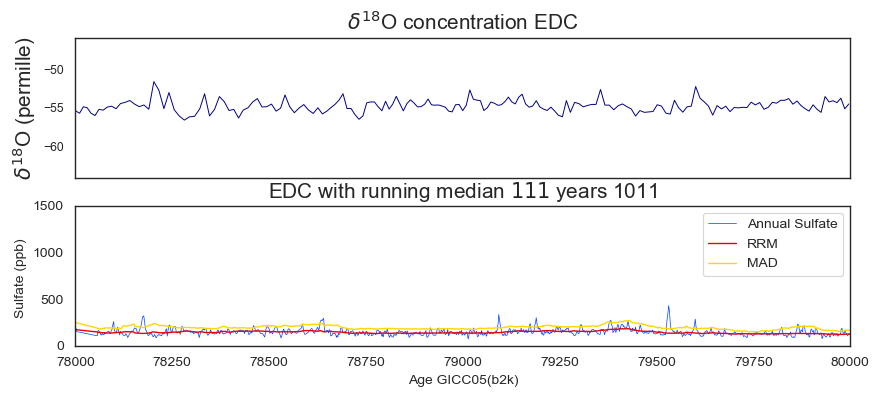

 69%|██████▊   | 35/51 [00:17<00:09,  1.66it/s]

1420 1 255
1 62 255


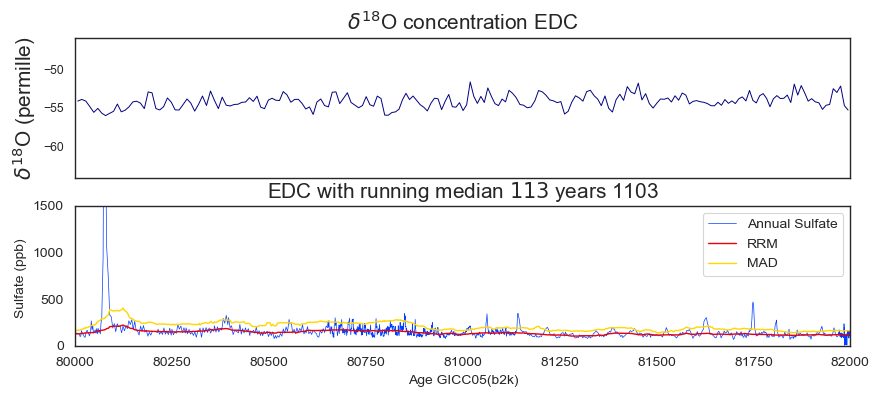

 71%|███████   | 36/51 [00:17<00:09,  1.61it/s]

1356 1 50
1 134 50


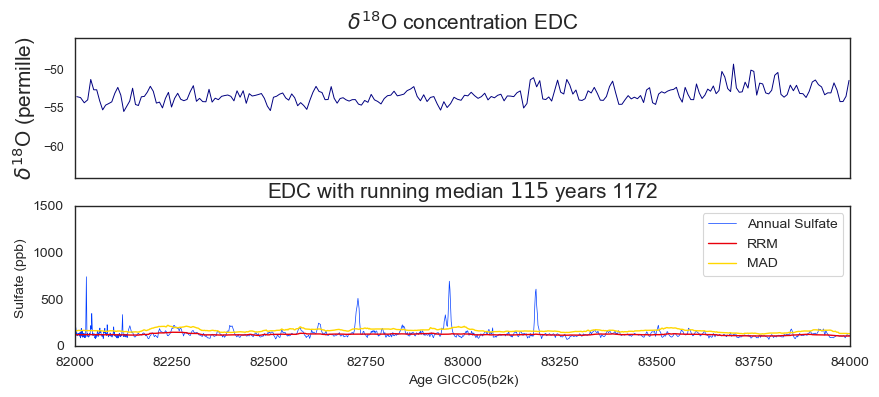

 73%|███████▎  | 37/51 [00:18<00:08,  1.61it/s]

1975 1 152
1 49 152


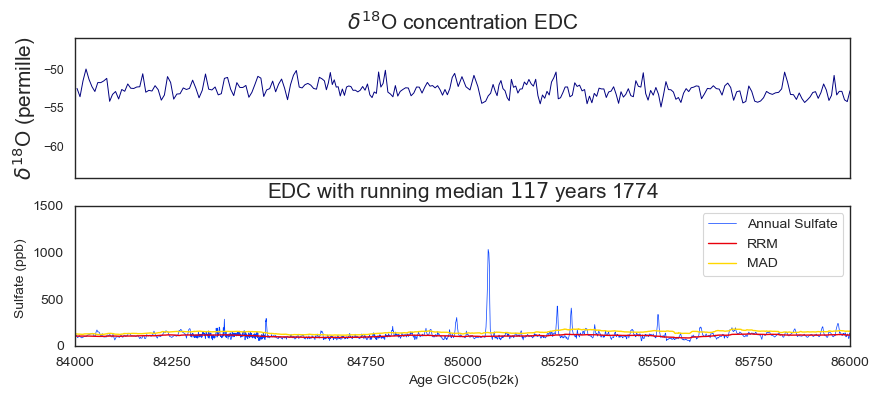

 75%|███████▍  | 38/51 [00:19<00:09,  1.42it/s]

1426 1 48
1 79 48


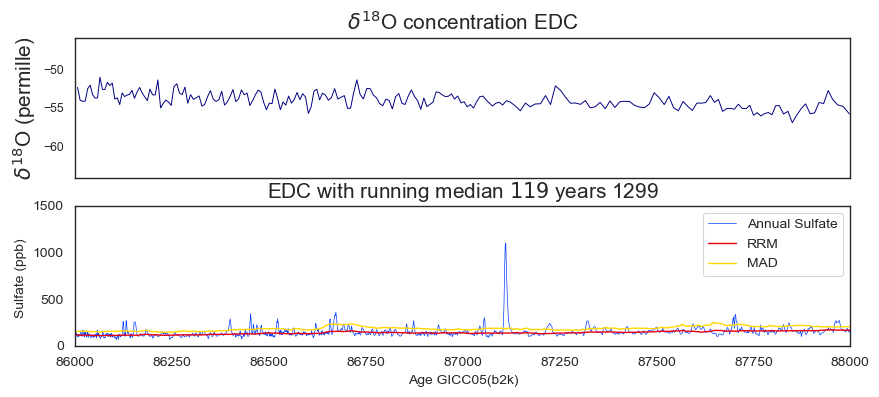

 76%|███████▋  | 39/51 [00:20<00:08,  1.46it/s]

846 1 48
1 60 48


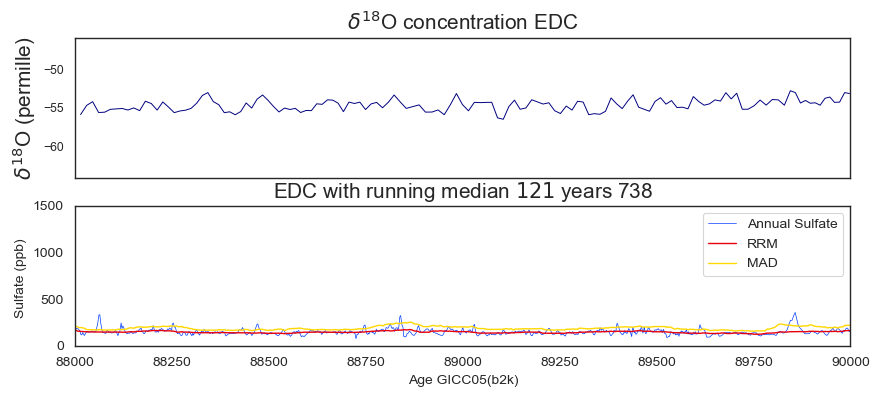

 78%|███████▊  | 40/51 [00:20<00:06,  1.59it/s]

887 1 27
1 36 27


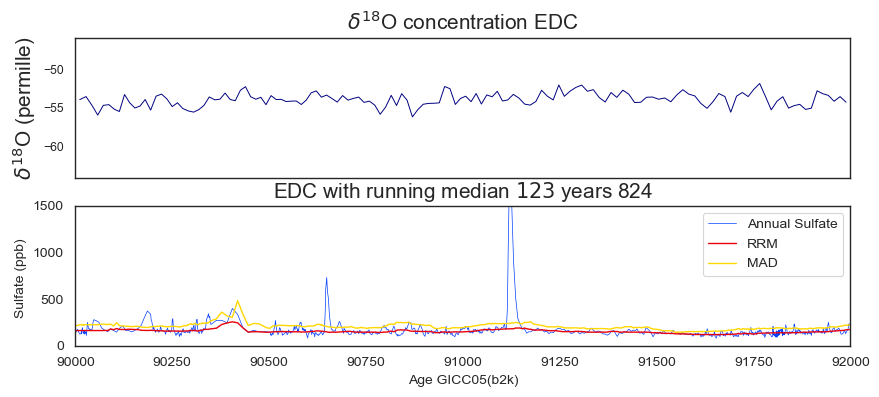

 80%|████████  | 41/51 [00:20<00:05,  1.71it/s]

971 1 27
1 69 27


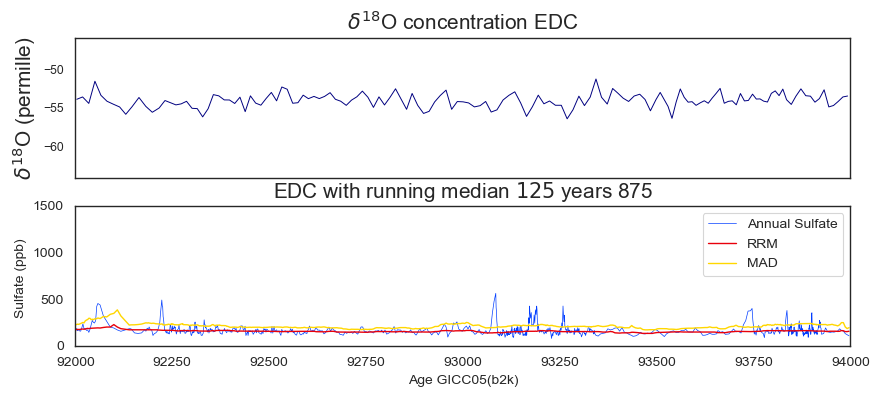

 82%|████████▏ | 42/51 [00:21<00:05,  1.75it/s]

984 1 17
1 95 17


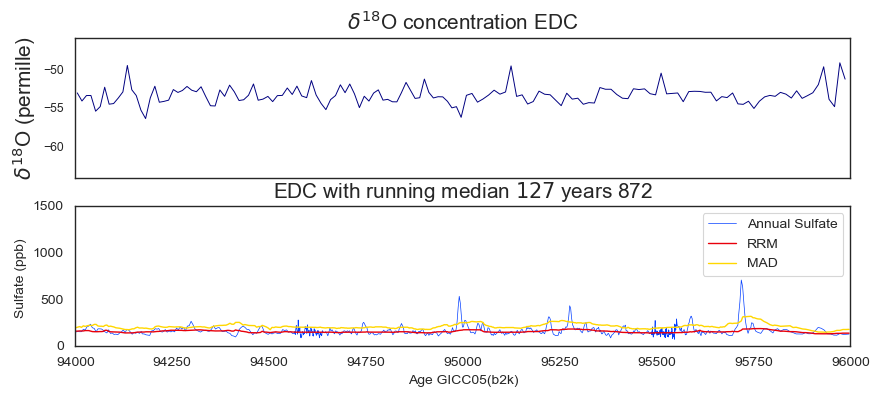

 84%|████████▍ | 43/51 [00:22<00:04,  1.79it/s]

1008 1 75
1 16 75


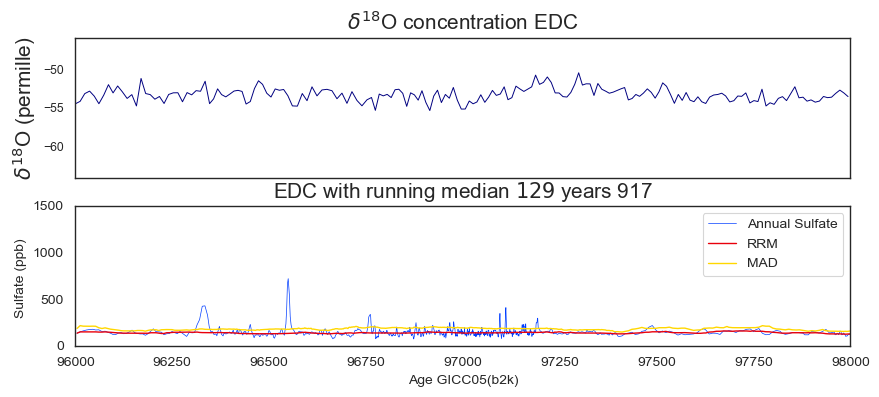

 86%|████████▋ | 44/51 [00:22<00:04,  1.71it/s]

1240 1 42
1 30 42


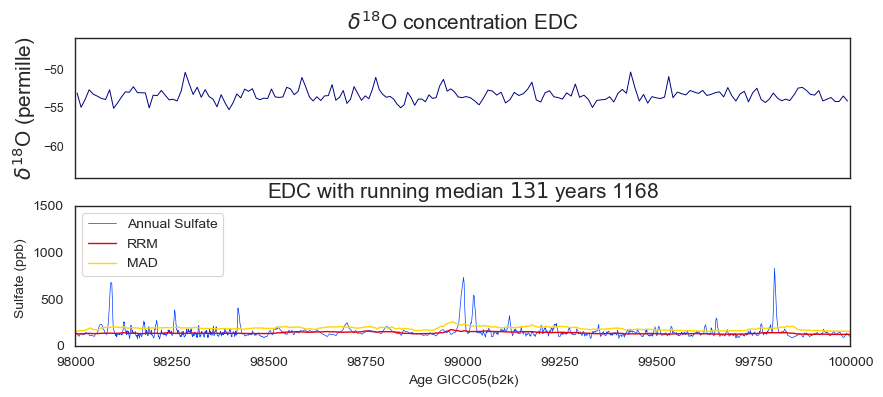

 88%|████████▊ | 45/51 [00:23<00:04,  1.48it/s]

1036 1 64
1 49 64


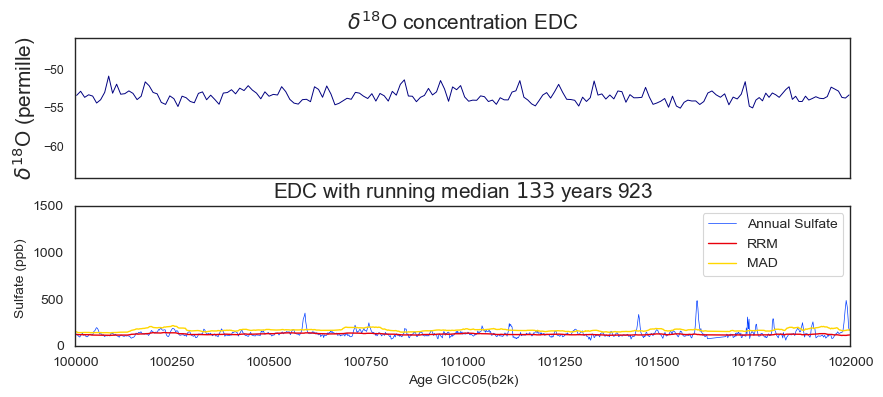

 90%|█████████ | 46/51 [00:24<00:03,  1.59it/s]

1222 1 40
1 60 40


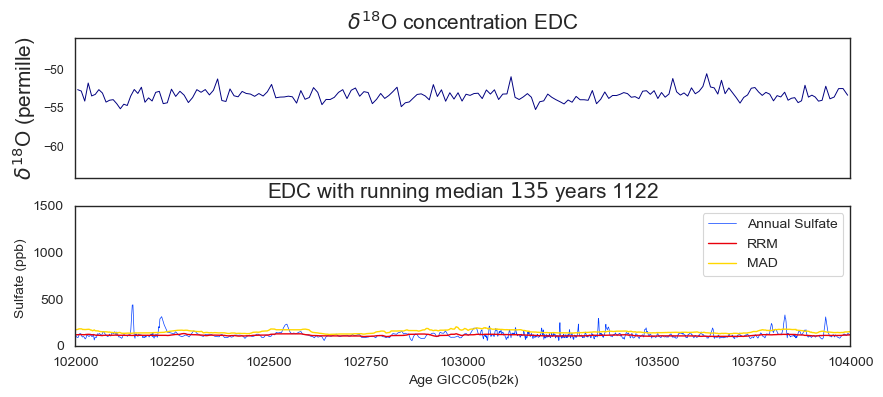

 92%|█████████▏| 47/51 [00:24<00:02,  1.49it/s]

1184 1 33
1 62 33


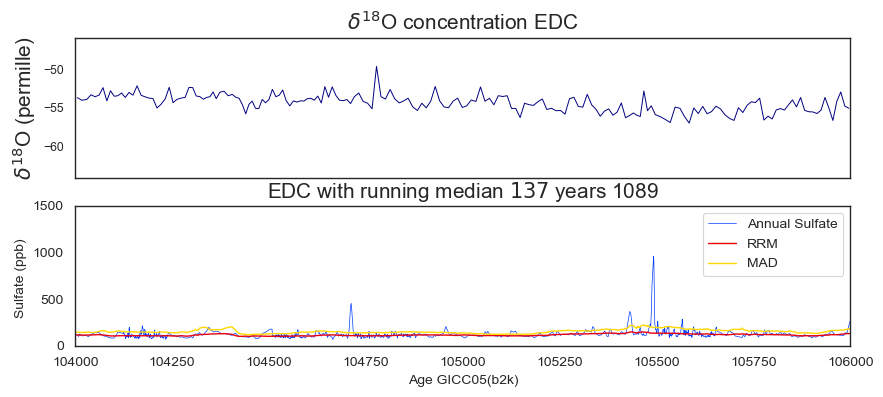

 94%|█████████▍| 48/51 [00:25<00:01,  1.54it/s]

1214 1 161
1 36 161


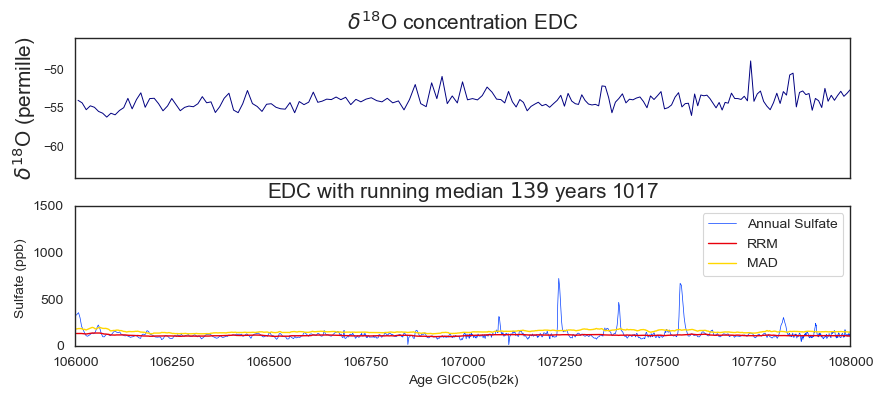

 96%|█████████▌| 49/51 [00:26<00:01,  1.58it/s]

1452 1 76
1 151 76


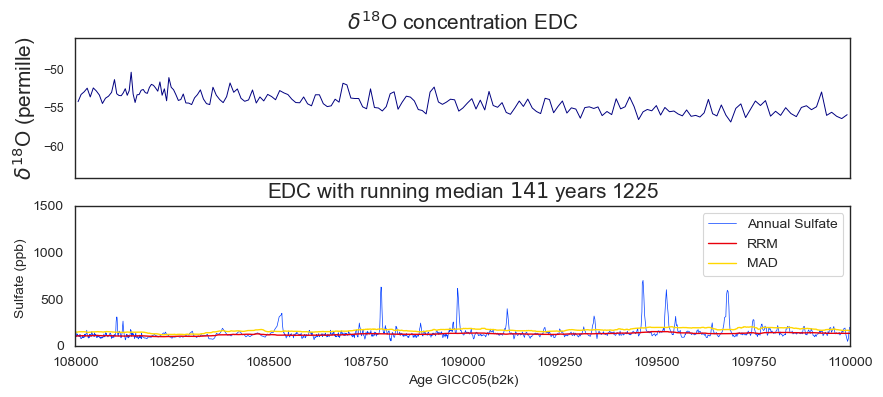

 98%|█████████▊| 50/51 [00:26<00:00,  1.54it/s]

524 1 0


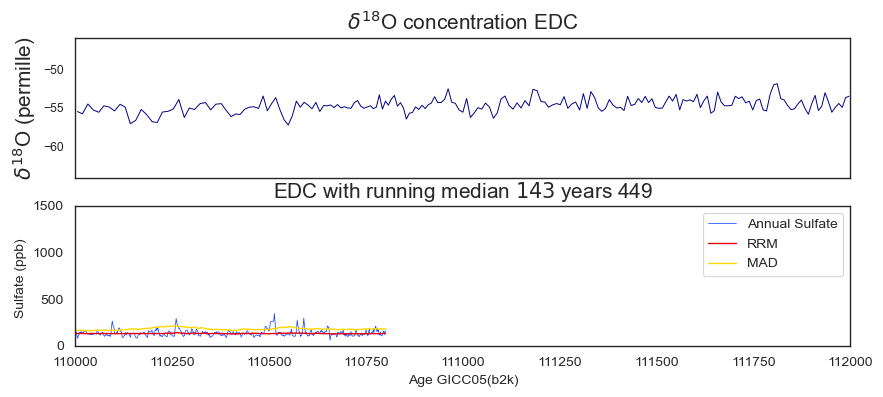

 98%|█████████▊| 50/51 [00:27<00:00,  1.84it/s]


In [45]:
%matplotlib inline
data_points = []
EDC_sulfate_no_volc = np.zeros((len(EDC_age)))
EDC_RM = np.zeros((len(EDC_age)))
EDC_MAD = np.zeros((len(EDC_age)))
EDC_RRM = np.zeros((len(EDC_age)))
EDC_RMAD = np.zeros((len(EDC_age)))

for i in tqdm(range(len(EDC_age_list)-1)):
    idx = np.where((EDC_age >= EDC_age_list[i] - EDC_filt[i]) & (EDC_age <= EDC_age_list[i+1] + EDC_filt[i] ))
    idx2 = np.where((EDC_age >= EDC_age_list[i]) & (EDC_age <= EDC_age_list[i+1]))
    
    idx_filt_1 = len(np.where((EDC_age >= EDC_age_list[i] - EDC_filt[i]) & (EDC_age < EDC_age_list[i]))[0])
    idx_filt_2 = len(np.where((EDC_age <= EDC_age_list[i+1] + EDC_filt[i]) & (EDC_age > EDC_age_list[i+1]))[0])
    
    #print(np.where((EDC_age <= EDC_age_list[i+1] + EDC_filt[i]) & (EDC_age > EDC_age_list[i+1])))
    #print(len(EDC_age[idx2]))
    #print(idx_filt_2)
    
    RM = running_median(EDC_age[idx], EDC_sulfate[lim_EDC][idx], EDC_filt[i])
    exl_volcanic = exl_volcanism(EDC_age[idx], EDC_sulfate[lim_EDC][idx],EDC_filt[i], z=3)
    RRM = running_median(EDC_age[idx], exl_volcanic, EDC_filt[i])
    MAD = median_of_absolute_deviation(EDC_age[idx], EDC_sulfate[lim_EDC][idx], EDC_filt[i], z=3)
    RMAD = median_of_absolute_deviation(EDC_age[idx], exl_volcanic, EDC_filt[i], z=3)
        
    EDC_age_s = EDC_age[idx2]
    EDC_sulfate_s = EDC_sulfate[lim_EDC][idx2]
    print(len(RM), len(idx2), idx_filt_2)
    
    EDC_sulfate_count = len(EDC_age[idx2])
    
    data_points.append(EDC_sulfate_count)
    
    idx_ox = np.where((EDC_d18O_age > EDC_age_list[i]) & (EDC_d18O_age < EDC_age_list[i+1]))

    if i == 0: 
        EDC_RM[idx2] = RM[:-idx_filt_2]
        EDC_sulfate_no_volc[idx2] = exl_volcanic[: -idx_filt_2]
        EDC_RRM[idx2] = RRM[: -idx_filt_2]
        EDC_MAD[idx2] = MAD[: -idx_filt_2]
        EDC_RMAD[idx2] = RMAD[: -idx_filt_2]
        
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  figsize=(10, 4))
        
        ax1.set_title('$\delta^{18}$O concentration EDC', fontsize=15)
        ax1.plot(EDC_d18O_age[idx_ox], EDC_d18O[idx_ox], color='navy', linewidth=.7)
        ax1.set_ylim(-64,-46)
        ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
    
        ax2.plot(EDC_age_s, EDC_sulfate_s, linewidth=.5, label = 'Annual Sulfate', color='b')
        ax2.plot(EDC_age_s, RRM[: -idx_filt_2], linewidth = 1, label = 'RRM', color='r')
        plt.plot(EDC_age_s, RMAD[: -idx_filt_2], linewidth=1, label = 'MAD', color='gold')
        plt.legend(fontsize=10)
        ax2.set_xlabel('Age GICC05(b2k)', fontsize=10)
        ax2.set_ylabel('Sulfate (ppb) ', fontsize=10)
        ax2.set_ylim(0,1500)
        ax2.set_xlim(EDC_age_list[i],EDC_age_list[i+1])
        plt.legend(fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        ax2.set_title('EDC with running median $'+str(int(EDC_filt[i]))+'$ years ' + str(int(EDC_sulfate_count)), fontsize=15)
        #plt.savefig('EDC_' + str(EDC_age_list[i])+ '_' + str(EDC_age_list[i+1]) + '_' + str(EDC_filt[i]) + '_RM.jpg', dpi=1000, bbox_inches='tight')  
        plt.show()
        
        
    elif i == len(EDC_age_list) - 2:
        
        EDC_RM[idx2] = RM[idx_filt_1:]
        EDC_sulfate_no_volc[idx2] = exl_volcanic[idx_filt_1:]
        EDC_RRM[idx2] = RRM[idx_filt_1: ]
        EDC_MAD[idx2] = MAD[idx_filt_1: ]
        EDC_RMAD[idx2] = RMAD[idx_filt_1: ]
        
        
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  figsize=(10, 4))
        
        ax1.set_title('$\delta^{18}$O concentration EDC', fontsize=15)
        ax1.plot(EDC_d18O_age[idx_ox], EDC_d18O[idx_ox], color='navy', linewidth=.7)
        ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
        ax1.set_ylim(-64,-46)
        plt.xlim(10000,12000)
    
        ax2.plot(EDC_age_s, EDC_sulfate_s, linewidth=.5, label = 'Annual Sulfate', color='b')
        ax2.plot(EDC_age_s, RRM[idx_filt_1:], linewidth = 1, label = 'RRM', color='r')
        plt.plot(EDC_age_s, RMAD[idx_filt_1:], linewidth=1, label = 'MAD', color='gold')
        plt.legend(fontsize=10)
        ax2.set_xlabel('Age GICC05(b2k)', fontsize=10)
        ax2.set_ylabel('Sulfate (ppb) ', fontsize=10)
        ax2.set_ylim(0,1500)
        ax2.set_xlim(EDC_age_list[i],EDC_age_list[i+1])
        plt.legend(fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        ax2.set_title('EDC with running median $'+str(int(EDC_filt[i]))+'$ years ' + str(int(EDC_sulfate_count)), fontsize=15)
        #plt.savefig('EDC_' +str(EDC_age_list[i])+ '_' + str(EDC_age_list[i+1]) + '_' + str(EDC_filt[i]) + '_RM.jpg', dpi=1000, bbox_inches='tight')  
        plt.show()
        
        break
   
    else: 
        print(len(idx2), idx_filt_1, idx_filt_2)
        EDC_RM[idx2] = RM[idx_filt_1: -idx_filt_2]
        EDC_sulfate_no_volc[idx2] = exl_volcanic[idx_filt_1: -idx_filt_2]
        EDC_RRM[idx2] = RRM[idx_filt_1: -idx_filt_2]
        EDC_MAD[idx2] = MAD[idx_filt_1: -idx_filt_2]
        EDC_RMAD[idx2] = RMAD[idx_filt_1: -idx_filt_2]
        
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  figsize=(10, 4))
        
        ax1.set_title('$\delta^{18}$O concentration EDC', fontsize=15)
        ax1.plot(EDC_d18O_age[idx_ox], EDC_d18O[idx_ox], color='navy', linewidth=.7)
        ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
        ax1.set_ylim(-64,-46)
        plt.xlim(10000,12000)
    
        ax2.plot(EDC_age_s, EDC_sulfate_s, linewidth=.5, label = 'Annual Sulfate', color='b')
        ax2.plot(EDC_age_s, RRM[idx_filt_1: -idx_filt_2], linewidth = 1, label = 'RRM', color='r')
        plt.plot(EDC_age_s, RMAD[idx_filt_1:-idx_filt_2], linewidth=1, label = 'MAD', color='gold')
        plt.legend(fontsize=10)
        ax2.set_xlabel('Age GICC05(b2k)', fontsize=10)
        ax2.set_ylabel('Sulfate (ppb) ', fontsize=10)
        ax2.set_ylim(0,1500)
        ax2.set_xlim(EDC_age_list[i],EDC_age_list[i+1])
        plt.legend(fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        ax2.set_title('EDC with running median $'+str(int(EDC_filt[i]))+'$ years ' + str(int(EDC_sulfate_count)), fontsize=15)
        #plt.savefig('EDC_' +str(EDC_age_list[i])+ '_' + str(EDC_age_list[i+1])  + '_' + str(EDC_filt[i]) + '_RM.jpg', dpi=1000, bbox_inches='tight')  
        plt.show()
        

### Data resolution and median filter for each 2k interval 

In [26]:
print(tabulate({'Data res.': data_points, 'Interval1': EDC_age_list[:-1], 'Interval2': EDC_age_list[1:], 'Filter': EDC_filt[:-1]}, headers="keys", tablefmt='fancy_grid'))

╒═════════════╤═════════════╤═════════════╤══════════╕
│   Data res. │   Interval1 │   Interval2 │   Filter │
╞═════════════╪═════════════╪═════════════╪══════════╡
│           0 │       10000 │       12000 │       45 │
├─────────────┼─────────────┼─────────────┼──────────┤
│        1075 │       12000 │       14000 │       45 │
├─────────────┼─────────────┼─────────────┼──────────┤
│        1216 │       14000 │       16000 │       47 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         885 │       16000 │       18000 │       49 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         579 │       18000 │       20000 │       51 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         570 │       20000 │       22000 │       53 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         644 │       22000 │       24000 │       55 │
├─────────────┼─────────────┼─────────────┼──────────┤
│         509 │       24000 │       26000 │       57 │
├─────────

### Making sure the background arrays have been saved correctly 

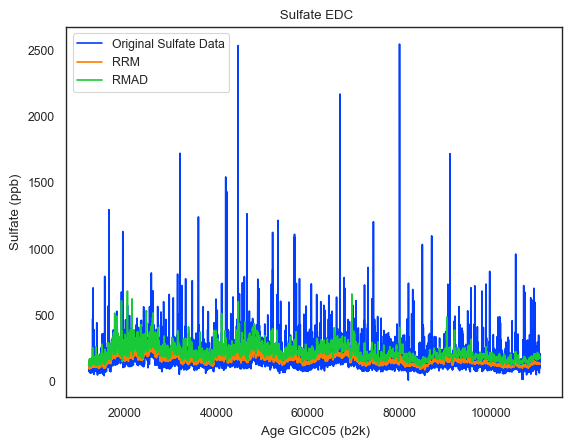

In [27]:
%matplotlib inline
plt.figure()
plt.plot(EDC_age, EDC_sulfate[lim_EDC],'-', label='Original Sulfate Data')
#plt.plot(EDC_age, EDC_RM, '-', label='RM')
plt.plot(EDC_age, EDC_RRM, '-', label='RRM')
#plt.plot(EDC_age, EDC_MAD, '-', label='MAD')
plt.plot(EDC_age, EDC_RMAD, '-', label='RMAD')
#plt.xlim(40000,42000)
plt.xlabel(' Age GICC05 (b2k)')
plt.ylabel('Sulfate (ppb)')
plt.title(' Sulfate EDC')
plt.legend()
plt.show()

In [28]:
# storing the arrays 

%store EDC_RRM
%store EDC_RMAD

Stored 'EDC_RRM' (ndarray)
Stored 'EDC_RMAD' (ndarray)


### Plotting the number of data point and median filters in each 2k interval

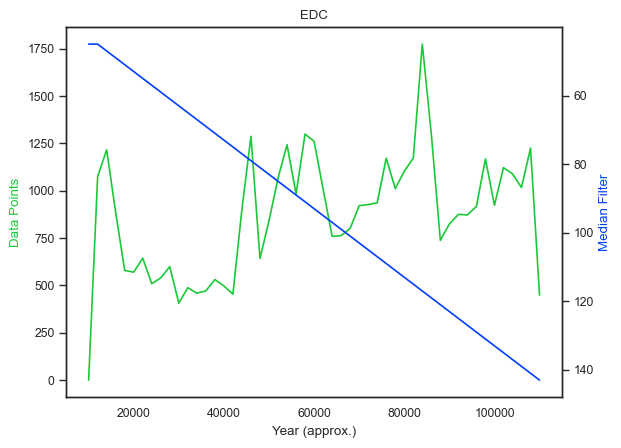

In [29]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(EDC_age_list[:-1], data_points, 'g')
ax2.plot(EDC_age_list[:-1], EDC_filt, 'b')
plt.title('EDC')

ax1.set_xlabel('Year (approx.)')
ax1.set_ylabel('Data Points', color='g')
ax2.set_ylabel('Median Filter', color='b')
ax2.invert_yaxis()
plt.savefig('EDC_data_points_2')

plt.show()

### Plotting all the sulfate deposition and comparing the results to Jiamei's bibolar results

In [30]:
%store -r JL_EDC_age_start
%store -r JL_EDC_age_middle
%store -r JL_EDC_age_end
%store -r JL_EDC_s

sulfate = []
y = []
sulfate_dep = []
year=[]


JL_EDC_age_start= JL_EDC_age_start[~np.isnan(JL_EDC_age_start)]
JL_EDC_age_end= JL_EDC_age_end[~np.isnan(JL_EDC_age_end)]

EDC_RRM = np.array(EDC_RRM)

for i in range(len(JL_EDC_age_end)):

    idx = np.where((EDC_age >=JL_EDC_age_start[i]) & (EDC_age <=JL_EDC_age_end[i]))

    if len(idx[0]) == 0:
        sulfate_dep.append(0.0)
        year.append(JL_EDC_age_start[i])
        continue
    else:
        s =   ( ( (EDC_sulfate[idx[0]] - all_RMAD_EDC[idx[0],3]) * EDC_thickness[idx[0]] / EDC_thinning_corr[idx[0]] ) * 0.917 )
        y = JL_EDC_age_start[i]
        sulfate_dep.append(np.nansum(s))
        year.append(y)
    
JL_EDC_s = np.array(JL_EDC_s, dtype='float64')
JL_EDC_age_start=np.array(JL_EDC_age_start, dtype='float64')

JL_EDC_s = JL_EDC_s[~np.isnan(JL_EDC_s)]
JL_EDC_age_start = JL_EDC_age_start[~np.isnan(JL_EDC_age_start)]

header = ('year', 'SO4-2', 'year Jiamei', 'sulfate dep Jiamei')

table = zip(year, sulfate_dep, JL_EDC_age_start, JL_EDC_s)

#print(tabulate(table, headers=header, floatfmt=".4f"))
sulfate_dep = np.array(sulfate_dep)
year = np.array(year)

corr = pearsonr(JL_EDC_s, sulfate_dep)
#corr


In [31]:
s_lin = np.array(JL_EDC_s).reshape((-1,1))
s_mydata = np.array(sulfate_dep).reshape((-1,1))

model = LinearRegression().fit(s_lin , s_mydata)
r_sq = model.score(s_lin,s_mydata)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

xx = np.arange(-5,201,1)
yy = xx  + model.intercept_
yy = yy.reshape((206,))

coefficient of determination: 0.0799129390593698
intercept: [-5.22146177]
slope: [[-0.09938523]]


### Plotting the whole period with d18O and sulfate + RRM 

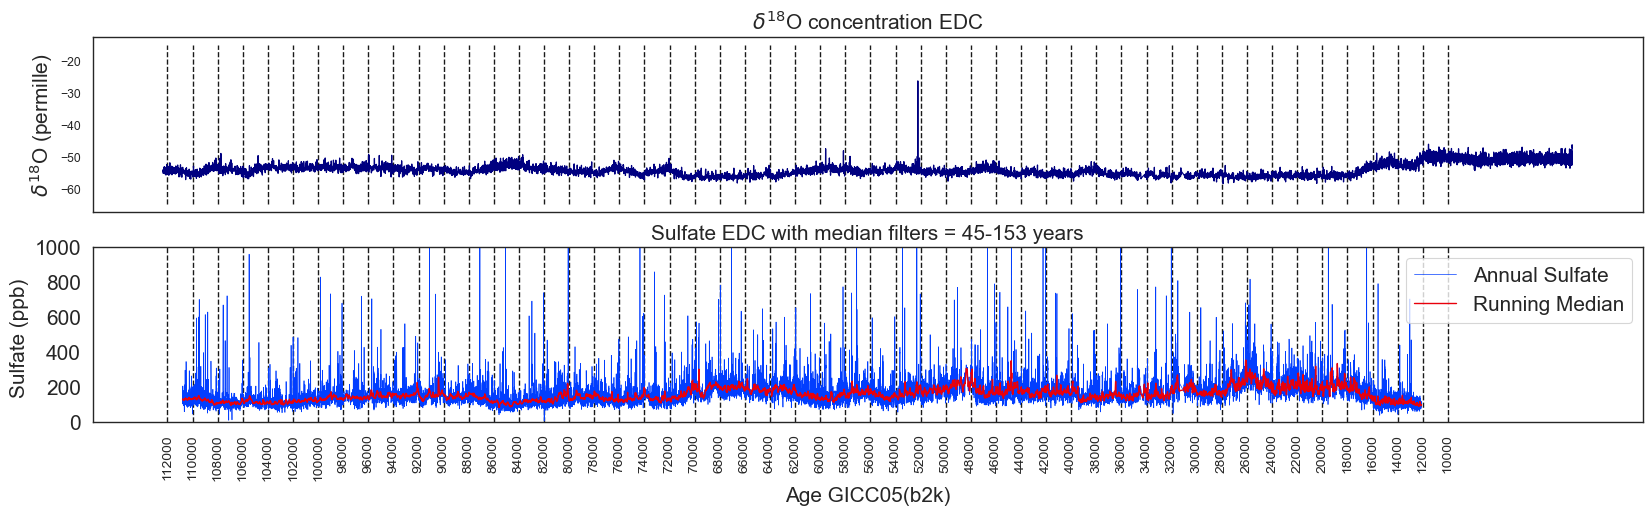

In [39]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,5), sharex=True)

label_vlines = np.arange(1,len(EDC_age_list)+1,1)

EDC_age_list_int = [int(x) for x in EDC_age_list]

ax1.vlines(EDC_age_list, -65,-15, color='k', linestyle='--', linewidth=1)

ax1.set_title('$\delta^{18}$O concentration EDC', fontsize=15)
ax1.plot(EDC_d18O_age, EDC_d18O, color='navy', linewidth=.9)
ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
#ax1.set_ylim(-60,-31)
#ax1.set_xlim(EDC_age[0], EDC_age[-1])
#ax1.vlines(EDC_age_list, -60,-20, color='k', linestyle='--', linewidth=1)

ax2.vlines(EDC_age_list, 0,1000, color='k', linestyle='--', linewidth=1)

ax2.set_title('Sulfate EDC with median filters = 45-153 years', fontsize=15)
ax2.plot(EDC_age, EDC_sulfate[lim_EDC], linewidth=.5, label = 'Annual Sulfate', color='b')
ax2.plot(EDC_age, EDC_RRM, linewidth = 1, label = 'Running Median', color='r')
#ax1.plot(EDC_annual_s, EDC_MAD[idx], linewidth=1, label = 'MAD', color='gold')
ax2.legend(fontsize=15, loc='upper right')
ax2.set_ylim(0,1000)
ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
plt.xticks(EDC_age_list, EDC_age_list_int, fontsize=10,rotation=90)
plt.yticks(fontsize=15)
plt.gca().invert_xaxis()
plt.xlabel('Age GICC05(b2k)', fontsize=15)
#ax2.set_xlim(EDC_age_list[i], EDC_age_list[i+1])
plt.savefig('EDC_RM_d18O_intevals.jpg', dpi=1000, bbox_inches='tight')
plt.show()

### Table with all eruptions 

In [40]:
print(tabulate({'Year eruption': year[sulfate_dep>20], 'Sulfate deposition': sulfate_dep[sulfate_dep>20]}, headers="keys", tablefmt='fancy_grid'))

╒═════════════════╤══════════════════════╕
│   Year eruption │   Sulfate deposition │
╞═════════════════╪══════════════════════╡
│         12915.4 │              36.486  │
├─────────────────┼──────────────────────┤
│         13024.4 │              73.7693 │
├─────────────────┼──────────────────────┤
│         13209.3 │              25.9383 │
├─────────────────┼──────────────────────┤
│         13820   │              35.4495 │
├─────────────────┼──────────────────────┤
│         15226.6 │              29.8046 │
├─────────────────┼──────────────────────┤
│         15552.2 │              75.5809 │
├─────────────────┼──────────────────────┤
│         16320.8 │              42.4826 │
├─────────────────┼──────────────────────┤
│         16459.1 │              95.7767 │
├─────────────────┼──────────────────────┤
│         16748.1 │              28.973  │
├─────────────────┼──────────────────────┤
│         19204.1 │              34.5085 │
├─────────────────┼──────────────────────┤
│         1

### Plotting background sulfate, accumulation rate, thinning and d18O for EDC

Text(0.5, 0, 'Depth (m)')

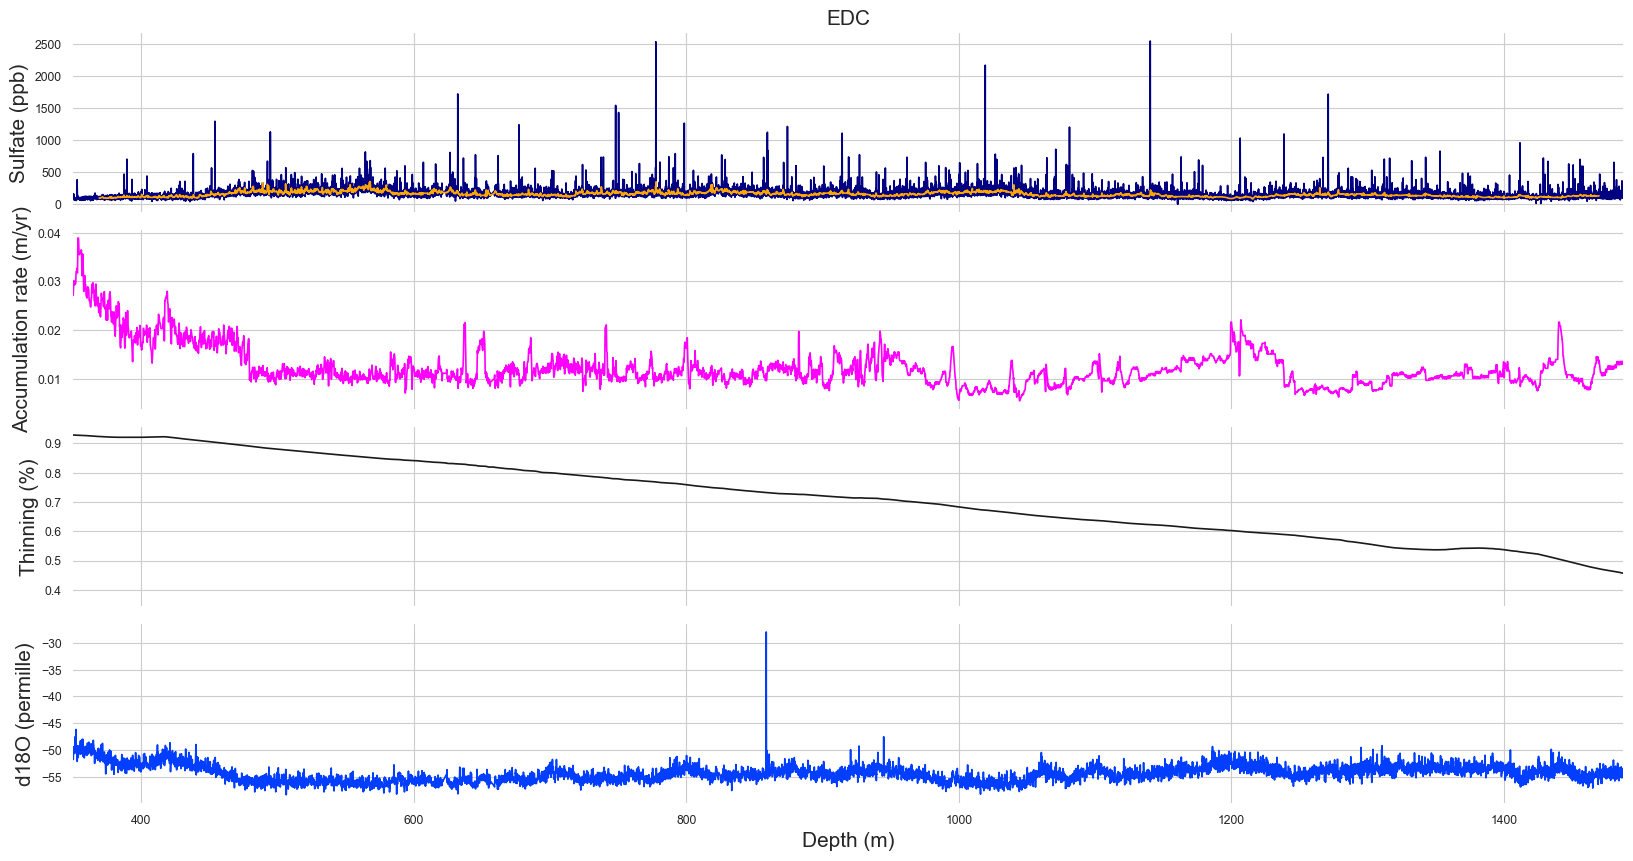

In [41]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, figsize=(20,10), subplot_kw=dict(frameon=False)) # frameon=False removes frames

plt.subplots_adjust(hspace=.1)

ax1.grid('minor','both')
ax2.grid('minor','both')
ax3.grid('minor','both')
ax4.grid('minor','both')

ax1.set_title('EDC', fontsize=15)

ax1.plot(EDC_depth, EDC_sulfate, color='navy')
ax1.plot(EDC_depth[lim_EDC], EDC_RRM, color='orange')
ax1.set_ylabel('Sulfate (ppb)', fontsize=15)

ax2.plot(EDC_depth, EDC_acc_corr, color='magenta')
ax2.set_ylabel('Accumulation rate (m/yr)', fontsize=15)

ax3.plot(EDC_depth[1:], EDC_thinning_corr, color='k')
ax3.set_ylabel('Thinning (%)', fontsize=15)

ax4.plot(EDC_depth, EDC_d18O_wdepth, color='b')
ax4.set_ylabel('d18O (permille)', fontsize=15)

plt.xlim(np.nanmin(EDC_depth), np.nanmax(EDC_d18O_depth))
plt.xlabel('Depth (m)', fontsize=15)

#plt.savefig('EDC_thinning_d18O_acc_sulfate', dpi=1000, bbox_inches = 'tight')

(0.011672406531927219,
 0.027968193425762546,
 0.005483069487467352,
 12128.768794492484,
 110800.60364147241)

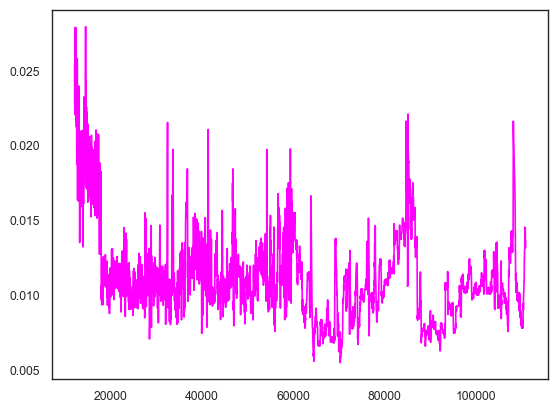

In [42]:
plt.figure()
plt.plot(EDC_age, EDC_acc_corr[lim_EDC], color='magenta')

mean_accumulation_EDC = np.nanmean(EDC_acc_corr[lim_EDC])
max_accumulation_EDC = np.nanmax(EDC_acc_corr[lim_EDC])
min_accumulation_EDC = np.nanmin(EDC_acc_corr[lim_EDC])
mean_accumulation_EDC , max_accumulation_EDC, min_accumulation_EDC,EDC_age[0], EDC_age[-1]

### Plotting only the background sulfate (inverse) against d18O for the whole period 

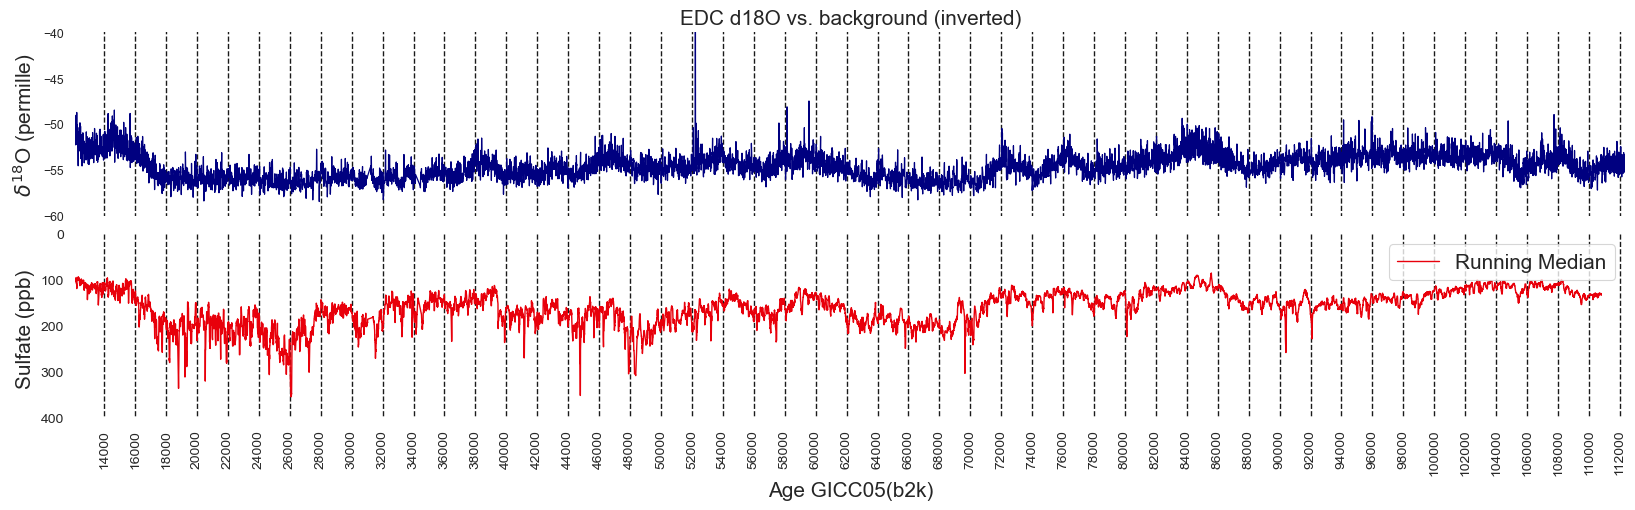

In [43]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,5), sharex=True, subplot_kw=dict(frameon=False))

label_vlines = np.arange(1,len(EDC_age_list)+1,1)

plt.subplots_adjust(hspace=.1)

EDC_age_list_int = [int(x) for x in EDC_age_list]

ax1.vlines(EDC_age_list, -65,-15, color='k', linestyle='--', linewidth=1)

ax1.set_title('EDC d18O vs. background (inverted)', fontsize=15)
ax1.plot(EDC_d18O_age, EDC_d18O, color='navy', linewidth=.9)
ax1.set_ylabel('$\delta^{18}$O (permille)', fontsize=15)
ax1.set_ylim(-60,-40)
#ax1.set_xlim(EDC_age[0], EDC_age[-1])
#ax1.vlines(EDC_age_list, -60,-20, color='k', linestyle='--', linewidth=1)

ax2.vlines(EDC_age_list, 0,1000, color='k', linestyle='--', linewidth=1)

#ax2.set_title('Sulfate EDC with median filters = 45-153 years', fontsize=15)
ax2.plot(EDC_age, EDC_RRM, linewidth = 1, label = 'Running Median', color='r')
#ax1.plot(EDC_annual_s, EDC_MAD[idx], linewidth=1, label = 'MAD', color='gold')
ax2.legend(fontsize=15, loc='upper right')
ax2.set_ylim(400,0)
ax2.set_xlabel('Age GICC05(b2k)', fontsize=15)
ax2.set_ylabel('Sulfate (ppb) ', fontsize=15)
plt.xticks(EDC_age_list, EDC_age_list_int, fontsize=10,rotation=90)
plt.yticks(fontsize=10)
plt.gca().invert_xaxis()
plt.xlabel('Age GICC05(b2k)', fontsize=15)
#ax2.set_xlim(EDC_age_list[i], EDC_age_list[i+1])

ax2.set_xlim(np.nanmin(EDC_age), np.nanmax(EDC_d18O_age))
plt.savefig('EDC_RM_d18O_intevals.jpg', dpi=1000, bbox_inches='tight')
plt.show()

### Plot of the sulfate deposition against the sulfate peaks and RRM 

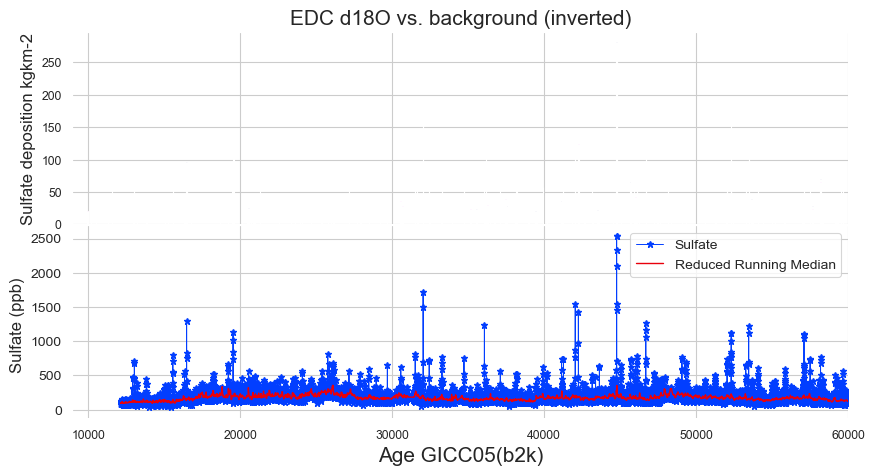

In [44]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,5), sharex=True, subplot_kw=dict(frameon=False))

label_vlines = np.arange(1,len(EDC_age_list)+1,1)

plt.subplots_adjust(hspace=.01)

EDC_age_list_int = [int(x) for x in EDC_age_list]

ax1.set_title('EDC d18O vs. background (inverted)', fontsize=15)
ax1.bar(year[sulfate_dep > 20], sulfate_dep[sulfate_dep > 20], width=10, color='navy')
ax1.set_ylabel('Sulfate deposition kgkm-2', fontsize=12)
ax1.bar(EDC_L_age[EDC_L_dep > 20], EDC_L_dep[EDC_L_dep > 20], width = 10, color='magenta')
#ax1.set_xlim(EDC_age[0], EDC_age[-1])
#ax1.vlines(EDC_age_list, -60,-20, color='k', linestyle='--', linewidth=1)

ax1.grid()
ax2.grid()

#ax2.set_title('Sulfate EDC with median filters = 45-153 years', fontsize=15)
ax2.plot(EDC_age, EDC_sulfate[lim_EDC], linewidth=.7, marker='*', label= 'Sulfate', color='b')
ax2.plot(EDC_age, EDC_RRM, linewidth = 1, label = 'Reduced Running Median', color='r')
#ax1.plot(EDC_annual_s, EDC_MAD[idx], linewidth=1, label = 'MAD', color='gold')
ax2.legend(fontsize=10, loc='upper right')
#ax2.set_ylim(400,0)
ax2.set_xlabel('Age GICC05(b2k)', fontsize=12)
ax2.set_ylabel('Sulfate (ppb) ', fontsize=12)
#plt.xticks(EDC_age_list, EDC_age_list_int, fontsize=10,rotation=90)
plt.yticks(fontsize=10)
plt.gca().invert_xaxis()
plt.xlabel('Age GICC05(b2k)', fontsize=15)
#ax2.set_xlim(EDC_age_list[i], EDC_age_list[i+1])
ax2.set_xlim(9000,60000)

#ax2.set_xlim(np.nanmin(EDC_age), np.nanmax(EDC_age))
#plt.savefig('EDC_RM_d18O_intevals.jpg', dpi=1000, bbox_inches='tight')
plt.show()